In [14]:
#%%

In [15]:
%%capture
%pip install -q pandas numpy scipy matplotlib seaborn scikit-learn selenium webdriver-manager

In [16]:
#%%
# 数据处理与分析库
import pandas as pd
import numpy as np
from scipy import stats
from typing import List, Dict, Optional, Union

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns
import logging
# 可视化配置
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
sns.set_theme(font="SimHei", font_scale=0.8)

# 机器学习库
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# 网页爬取相关库
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.edge.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common import (NoSuchElementException, 
                             StaleElementReferenceException, 
                             TimeoutException)
from webdriver_manager.microsoft import EdgeChromiumDriverManager

# 并发处理
from concurrent.futures import ThreadPoolExecutor, as_completed

# 其他工具库
import json
import re
import os
import time
import glob
import warnings
warnings.filterwarnings('ignore')

In [17]:
class FangDataCrawler:
    """房天下数据爬虫类
    
    功能：爬取指定区域的二手房、租房数据，支持并发爬取、单区域/全区域数据保存与合并。
    默认爬取区域：张家口市张北、桥西、下花园、怀来四区。
    
    Attributes:
        areas: 二手房区域配置列表
        rent_areas: 租房区域配置列表  
        default_max_page: 默认最大爬取页数
        logger: 日志记录器
    """
    
    # 常量配置
    DEFAULT_WAIT_TIMEOUT = 10
    MAX_RETRY_ATTEMPTS = 3
    RETRY_DELAY = 2
    
    def __init__(self, second_hand_areas=None, rent_areas=None, default_max_page=1):
        """
        初始化房天下数据爬虫类
        
        Args:
            second_hand_areas: 二手房区域列表，格式为包含URL和区域名称的字典列表
            rent_areas: 租房区域列表，格式与二手房区域列表相同
            default_max_page: 默认最大爬取页数
        """
        self._setup_logging()
        
        # 初始化区域配置
        self.areas = second_hand_areas or self._get_default_second_hand_areas()
        self.rent_areas = rent_areas or self._get_default_rent_areas()
        self.default_max_page = default_max_page
        
        self.logger.info(f"爬虫初始化完成，二手房区域: {len(self.areas)}个, 租房区域: {len(self.rent_areas)}个")

    def _setup_logging(self):
        """配置日志系统"""
        self.logger = logging.getLogger(__name__)
        if not self.logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter(
                '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
            )
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)
            self.logger.setLevel(logging.INFO)

    @staticmethod
    def _get_default_second_hand_areas() -> List[Dict[str, str]]:
        """获取默认二手房区域配置"""
        return [
            {"url": "https://zhangjiakou.esf.fang.com/house-a011426/h30-i31/", "name": "张北"},
            {"url": "https://zhangjiakou.esf.fang.com/house-a014962/h30-i31/", "name": "桥西"},
            {"url": "https://zhangjiakou.esf.fang.com/house-a014963/h30-i31/", "name": "下花园"},
            {"url": "https://zhangjiakou.esf.fang.com/house-a011434/h30-i31/", "name": "怀来"}
        ]

    @staticmethod
    def _get_default_rent_areas() -> List[Dict[str, str]]:
        """获取默认租房区域配置"""
        return [
            {"url": "https://zhangjiakou.zu.fang.com/house-a011426/", "name": "张北"},
            {"url": "https://zhangjiakou.zu.fang.com/house-a014962/", "name": "桥西"},
            {"url": "https://zhangjiakou.zu.fang.com/house-a014963/", "name": "下花园"},
            {"url": "https://zhangjiakou.zu.fang.com/house-a011434/", "name": "怀来"}
        ]

    def _init_driver(self) -> webdriver.Edge:
        """
        初始化并配置WebDriver实例
        
        Returns:
            配置完成的Edge WebDriver实例
            
        Raises:
            WebDriverException: 浏览器驱动初始化失败
        """
        try:
            options = Options()
            # 性能优化配置
            options.add_argument("--headless=new")
            options.add_argument("--disable-images")
            options.add_argument("--disable-gpu")
            options.add_argument("--no-sandbox")
            options.add_argument("--disable-dev-shm-usage")
            options.add_argument("--disable-blink-features=AutomationControlled")
            
            # 排除自动化特征
            options.add_experimental_option("excludeSwitches", ["enable-automation", "enable-logging"])
            options.add_experimental_option('useAutomationExtension', False)
            
            driver = webdriver.Edge(options=options)
            # 隐藏自动化特征
            driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")
            
            return driver
            
        except Exception as e:
            self.logger.error(f"WebDriver初始化失败: {e}")
            raise WebDriverException(f"无法初始化浏览器驱动: {e}")

    def _safe_find_element(self, parent, by: By, value: str, default=None):
        """安全查找元素，避免异常中断"""
        try:
            return parent.find_element(by, value)
        except NoSuchElementException:
            return default

    def _safe_get_text(self, element, default=None) -> str:
        """安全获取元素文本"""
        if element is None:
            return default
        try:
            text = element.text.strip()
            return text if text else default
        except Exception:
            return default

    def _extract_total_pages(self, driver, area_name: str, max_page: int, 
                           xpath: str, pattern: str) -> int:
        """提取总页数"""
        for attempt in range(self.MAX_RETRY_ATTEMPTS):
            try:
                wait = WebDriverWait(driver, self.DEFAULT_WAIT_TIMEOUT)
                total_page_element = wait.until(
                    EC.presence_of_element_located((By.XPATH, xpath))
                )
                total_page_text = total_page_element.text.strip()
                match = re.search(pattern, total_page_text)
                
                if match:
                    total_pages = int(match.group(1))
                    actual_pages = min(total_pages, max_page)
                    self.logger.info(f"{area_name} 总页数: {total_pages}, 实际爬取: {actual_pages}")
                    return actual_pages
                    
            except (TimeoutException, AttributeError, ValueError) as e:
                self.logger.warning(f"{area_name} 第{attempt+1}次提取总页数失败: {e}")
                if attempt < self.MAX_RETRY_ATTEMPTS - 1:
                    time.sleep(self.RETRY_DELAY)
        
        self.logger.info(f"{area_name} 使用默认最大页数: {max_page}")
        return max_page

    def _extract_second_hand_house_data(self, item, area_name: str) -> Dict[str, Optional[str]]:
        """提取单条二手房数据"""
        house_data = {"区域": area_name}
        
        try:
            # 提取houseid
            data_bg = item.get_attribute("data-bg")
            if data_bg:
                try:
                    data_bg_json = json.loads(data_bg)
                    house_data["houseid"] = data_bg_json.get("houseid")
                except json.JSONDecodeError:
                    house_data["houseid"] = None
            
            # 提取基本信息
            house_data.update({
                "房源标题": self._safe_get_text(
                    self._safe_find_element(item, By.XPATH, ".//span[@class='tit_shop']")
                ),
                "详情链接": self._safe_find_element(item, By.XPATH, ".//h4//a").get_attribute("href") 
                if self._safe_find_element(item, By.XPATH, ".//h4//a") else None
            })
            
            # 提取房屋详细信息
            self._extract_house_details(item, house_data)
            
            # 提取位置信息
            self._extract_location_info(item, house_data)
            
            # 提取价格信息
            self._extract_price_info(item, house_data)
            
            # 提取其他信息
            house_data.update({
                "房源标签": self._safe_get_text(
                    self._safe_find_element(item, By.XPATH, ".//p[@class='icon_bq']/span")
                ),
                "图片URL": self._safe_find_element(item, By.XPATH, ".//dt//img[@class='loadimg']").get_attribute("data-src")
                if self._safe_find_element(item, By.XPATH, ".//dt//img[@class='loadimg']") else None
            })
            
        except Exception as e:
            self.logger.error(f"提取房屋数据时出错: {e}")
            
        return house_data

    def _extract_house_details(self, item, house_data: Dict):
        """提取房屋详细信息"""
        tel_shop_elem = self._safe_find_element(item, By.XPATH, ".//p[@class='tel_shop']")
        if not tel_shop_elem:
            return
            
        tel_shop_text = self._safe_get_text(tel_shop_elem, "")
        
        # 使用正则表达式提取各种信息
        patterns = {
            "户型": r"(\d+室\d+厅)",
            "建筑面积": r"(\d+\.?\d*㎡)",
            "朝向": r"([东南西北]+向)",
            "建造年份": r"(\d{4}年建)"
        }
        
        for field, pattern in patterns.items():
            match = re.search(pattern, tel_shop_text)
            house_data[field] = match.group(1) if match else None
        
        # 提取楼层信息
        self._extract_floor_info(item, tel_shop_text, house_data)

    def _extract_floor_info(self, item, tel_shop_text: str, house_data: Dict):
        """提取楼层信息"""
        try:
            tel_shop_html = self._safe_find_element(item, By.XPATH, ".//p[@class='tel_shop']").get_attribute("innerHTML")
            floor_match = re.search(r'>([高中低底顶]+层)</a>\s*（共(\d+)层）', tel_shop_html)
            if floor_match:
                house_data["楼层类型"] = floor_match.group(1)
                house_data["总层数"] = floor_match.group(2)
                return
        except Exception:
            pass
            
        # 备选方案：从文本中提取
        floor_match = re.search(r'([高中低底顶]+层)\s*（共(\d+)层）', tel_shop_text)
        if floor_match:
            house_data["楼层类型"] = floor_match.group(1)
            house_data["总层数"] = floor_match.group(2)
        else:
            house_data["楼层类型"] = None
            house_data["总层数"] = None

    def _extract_location_info(self, item, house_data: Dict):
        """提取位置信息"""
        add_shop_elem = self._safe_find_element(item, By.XPATH, ".//p[@class='add_shop']")
        if add_shop_elem:
            house_data.update({
                "小区名称": self._safe_get_text(
                    self._safe_find_element(add_shop_elem, By.XPATH, ".//a")
                ),
                "区域位置": self._safe_get_text(
                    self._safe_find_element(add_shop_elem, By.XPATH, ".//span")
                )
            })

    def _extract_price_info(self, item, house_data: Dict):
        """提取价格信息"""
        price_elem = self._safe_find_element(item, By.XPATH, ".//dd[@class='price_right']")
        if price_elem:
            house_data.update({
                "总价": self._safe_get_text(
                    self._safe_find_element(price_elem, By.XPATH, ".//span[@class='red']")
                ),
                "单价": self._safe_get_text(
                    self._safe_find_element(price_elem, By.XPATH, ".//span[2]")
                )
            })

    def _navigate_to_next_page(self, driver, area_name: str, current_page: int, 
                             total_pages: int, next_page_xpath: str) -> bool:
        """导航到下一页"""
        if current_page >= total_pages:
            self.logger.info(f"{area_name} 已到达最后一页")
            return False
            
        for attempt in range(self.MAX_RETRY_ATTEMPTS):
            try:
                wait = WebDriverWait(driver, self.DEFAULT_WAIT_TIMEOUT)
                next_button = wait.until(
                    EC.element_to_be_clickable((By.XPATH, next_page_xpath))
                )
                
                driver.execute_script("arguments[0].click();", next_button)
                
                # 等待页面加载
                time.sleep(1)
                wait.until(EC.staleness_of(next_button))
                
                self.logger.debug(f"{area_name} 成功跳转到第 {current_page + 1} 页")
                return True
                
            except (TimeoutException, ElementClickInterceptedException) as e:
                self.logger.warning(f"{area_name} 第{attempt+1}次翻页失败: {e}")
                if attempt < self.MAX_RETRY_ATTEMPTS - 1:
                    time.sleep(self.RETRY_DELAY)
        
        self.logger.error(f"{area_name} 翻页失败，终止爬取")
        return False

    def crawl_second_hand_houses(self, url: str, area_name: str, max_page: Optional[int] = None) -> pd.DataFrame:
        """爬取指定区域的二手房数据"""
        max_page = max_page or self.default_max_page
        house_data = []
        
        self.logger.info(f"开始爬取 {area_name} 二手房数据")
        
        try:
            with self._init_driver() as driver:
                driver.get(url)
                driver.maximize_window()
                
                # 提取总页数
                total_pages = self._extract_total_pages(
                    driver, area_name, max_page,
                    "//span[@class='last' and contains(text(), '共') and contains(text(), '页')]",
                    r'共(\d+)页'
                )
                
                for page_num in range(1, total_pages + 1):
                    self.logger.info(f"{area_name} 正在爬取第 {page_num}/{total_pages} 页")
                    
                    # 爬取当前页数据
                    page_data = self._crawl_second_hand_page(driver, area_name)
                    if page_data:
                        house_data.extend(page_data)
                    
                    # 翻页
                    if page_num < total_pages:
                        if not self._navigate_to_next_page(
                            driver, area_name, page_num, total_pages,
                            "//p[@class='last']/a[text()='下一页']"
                        ):
                            break
                
        except KeyboardInterrupt:
            self.logger.info(f"{area_name} 爬取被用户中断")
        except Exception as e:
            self.logger.error(f"{area_name} 爬取过程发生错误: {e}")
        
        return self._process_crawl_result(house_data, area_name, "二手房")

    def _crawl_second_hand_page(self, driver, area_name: str) -> List[Dict]:
        """爬取单页二手房数据"""
        house_data = []
        try:
            wait = WebDriverWait(driver, self.DEFAULT_WAIT_TIMEOUT)
            shop_list = wait.until(
                EC.presence_of_element_located((By.XPATH, "//div[@class='shop_list shop_list_4']"))
            )
            
            house_items = shop_list.find_elements(By.XPATH, "./dl[@dataflag='bg']")
            self.logger.debug(f"{area_name} 找到 {len(house_items)} 条房源信息")
            
            for item in house_items:
                house_info = self._extract_second_hand_house_data(item, area_name)
                if house_info:
                    house_data.append(house_info)
                    
        except TimeoutException:
            self.logger.warning(f"{area_name} 页面加载超时")
        except Exception as e:
            self.logger.error(f"{area_name} 爬取页面时出错: {e}")
            
        return house_data

    def crawl_rent_houses(self, url: str, area_name: str, max_page: Optional[int] = None) -> Optional[pd.DataFrame]:
        """爬取指定区域的租房数据"""
        max_page = max_page or self.default_max_page
        house_data = []
        
        self.logger.info(f"开始爬取 {area_name} 租房数据")
        
        try:
            with self._init_driver() as driver:
                driver.get(url)
                
                # 提取总页数
                total_pages = self._extract_total_pages(
                    driver, area_name, max_page,
                    "//div[@class='fanye']//span[@class='txt' and contains(text(), '共')]",
                    r'共(\d+)页'
                )
                
                for current_page in range(1, total_pages + 1):
                    self.logger.info(f"{area_name} 正在爬取第 {current_page}/{total_pages} 页")
                    
                    # 爬取当前页数据
                    page_data = self._crawl_rent_page(driver, area_name)
                    if page_data:
                        house_data.extend(page_data)
                    
                    # 翻页
                    if current_page < total_pages:
                        if not self._navigate_rent_page(driver, area_name, current_page, url):
                            break
                
        except Exception as e:
            self.logger.error(f"{area_name} 租房数据爬取失败: {e}")
            return None
        
        return self._process_rent_result(house_data, area_name)

    def _crawl_rent_page(self, driver, area_name: str) -> List[Dict]:
        """爬取单页租房数据"""
        page_data = []
        try:
            wait = WebDriverWait(driver, self.DEFAULT_WAIT_TIMEOUT)
            wait.until(EC.presence_of_element_located((By.XPATH, "//div[@class='houseList']")))
            
            house_items = driver.find_elements(
                By.XPATH, "//div[@class='houseList']//dl[contains(@class, 'list') and contains(@class, 'hiddenMap')]"
            )
            
            for item in house_items:
                rent_info = self._extract_rent_house_data(item, area_name)
                if rent_info:
                    page_data.append(rent_info)
                    
        except TimeoutException:
            self.logger.warning(f"{area_name} 租房页面加载超时")
        except Exception as e:
            self.logger.error(f"{area_name} 爬取租房页面时出错: {e}")
            
        return page_data

    def _extract_rent_house_data(self, item, area_name: str) -> Optional[Dict]:
        """提取单条租房数据"""
        try:
            title_elem = self._safe_find_element(item, By.XPATH, ".//dd[contains(@class, 'info')]//p[contains(@class, 'title')]/a")
            if not title_elem:
                return None
                
            title = title_elem.get_attribute("title") or self._safe_get_text(title_elem)
            if not title:
                return None
                
            href = title_elem.get_attribute("href")
            detail_url = href if href.startswith("http") else f"https://zhangjiakou.zu.fang.com{href}"
            
            # 提取租金
            rent_elem = self._safe_find_element(item, By.XPATH, ".//dd[contains(@class, 'info')]//div[contains(@class, 'moreInfo')]//span[contains(@class, 'price')]")
            rent_text = self._safe_get_text(rent_elem, "").strip()
            rent = int(re.search(r'\d+', rent_text).group()) if re.search(r'\d+', rent_text) else None
            
            if not rent:
                return None
            
            # 提取房屋基本信息
            basic_info = self._extract_rent_basic_info(item)
            
            # 提取小区信息
            community = self._extract_community_info(item, title)
            
            # 提取其他信息
            direct_rent = "是" if self._safe_find_element(item, By.XPATH, ".//dt[contains(@class, 'img')]//span[contains(@class, 'smrz')]") else "否"
            
            feature_elems = item.find_elements(By.XPATH, ".//dd[contains(@class, 'info')]//p[contains(@class, 'mt12')]//span[contains(@class, 'note')]/a")
            feature_str = ",".join([self._safe_get_text(e) for e in feature_elems if self._safe_get_text(e)]) or None
            
            return {
                "区域": area_name,
                "房源标题": title,
                "小区名称": community,
                "户型": basic_info.get("house_type"),
                "面积": basic_info.get("area"),
                "朝向": basic_info.get("direction"),
                "租金(元/月)": rent,
                "是否业主直租": direct_rent,
                "房源特色": feature_str,
                "详情链接": detail_url
            }
            
        except Exception as e:
            self.logger.warning(f"提取租房数据时出错: {e}")
            return None

    def _extract_rent_basic_info(self, item) -> Dict[str, Optional[str]]:
        """提取租房基本信息"""
        basic_info_elem = self._safe_find_element(item, By.XPATH, ".//dd[contains(@class, 'info')]//p[contains(@class, 'font15') and contains(@class, 'bold')]")
        if not basic_info_elem:
            return {}
            
        basic_info_parts = [part.strip() for part in basic_info_elem.text.strip().split("|") if part.strip()]
        
        return {
            "house_type": basic_info_parts[1] if len(basic_info_parts) >= 2 else None,
            "area": basic_info_parts[2] if len(basic_info_parts) >= 3 else None,
            "direction": basic_info_parts[3] if len(basic_info_parts) >= 4 else None
        }

    def _extract_community_info(self, item, title: str) -> str:
        """提取小区信息"""
        community_elem = self._safe_find_element(item, By.XPATH, ".//dd[contains(@class, 'info')]//p[contains(@class, 'gray6')]//a[last()]/span")
        community = self._safe_get_text(community_elem)
        
        if not community and title:
            # 从标题中提取小区名
            community = title.split()[0] if title.split() else "未知小区"
            
        return community

    def _navigate_rent_page(self, driver, area_name: str, current_page: int, base_url: str) -> bool:
        """租房页面翻页"""
        for attempt in range(self.MAX_RETRY_ATTEMPTS):
            try:
                wait = WebDriverWait(driver, self.DEFAULT_WAIT_TIMEOUT)
                pagination = wait.until(EC.presence_of_element_located((By.XPATH, "//div[@class='fanye']")))
                
                # 尝试多种方式找到下一页按钮
                next_btn = None
                for xpath in [
                    "//div[@class='fanye']//a[contains(text(), '下一页')]",
                    f"//div[@class='fanye']//a[text()='{current_page + 1}']"
                ]:
                    try:
                        next_btn = wait.until(EC.element_to_be_clickable((By.XPATH, xpath)))
                        break
                    except TimeoutException:
                        continue
                
                if next_btn:
                    driver.execute_script("arguments[0].click();", next_btn)
                    wait.until(EC.text_to_be_present_in_element((By.XPATH, "//div[@class='fanye']//a[@class='pageNow']"), str(current_page + 1)))
                    return True
                    
            except Exception as e:
                self.logger.warning(f"{area_name} 第{attempt+1}次翻页失败: {e}")
        
        # 备选方案：直接URL跳转
        try:
            next_url = f"{base_url}i3{current_page + 1}/"
            driver.get(next_url)
            self.logger.info(f"{area_name} 通过URL跳转至第{current_page + 1}页")
            return True
        except Exception as e:
            self.logger.error(f"{area_name} 翻页失败: {e}")
            return False

    def _process_crawl_result(self, house_data: List[Dict], area_name: str, data_type: str) -> pd.DataFrame:
        """处理爬取结果"""
        if house_data:
            df = pd.DataFrame(house_data)
            self.logger.info(f"{area_name} {data_type}爬取完成，共获取 {len(house_data)} 条数据")
            return df
        else:
            self.logger.warning(f"{area_name} 未获取到任何{data_type}数据")
            return pd.DataFrame()

    def _process_rent_result(self, house_data: List[Dict], area_name: str) -> Optional[pd.DataFrame]:
        """处理租房爬取结果"""
        if not house_data:
            self.logger.warning(f"{area_name} 未爬取到有效租房数据")
            return None
            
        df = pd.DataFrame(house_data)
        csv_filename = f"{area_name}_租房数据.csv"
        try:
            df.to_csv(csv_filename, index=False, encoding="utf-8-sig")
            self.logger.info(f"{area_name} 租房数据已保存至 {csv_filename}")
            return df
        except Exception as e:
            self.logger.error(f"保存租房数据失败: {e}")
            return df

    def crawl_all_data(self, max_page: Optional[int] = None, max_workers: int = 4) -> Dict[str, pd.DataFrame]:
        """爬取所有数据，支持并发处理"""
        max_page = max_page or self.default_max_page
        
        results = {
            "second_hand": None,
            "rent": None
        }
        
        self.logger.info("开始并发爬取所有数据...")
        
        # 并发爬取二手房数据
        results["second_hand"] = self._crawl_all_second_hand(max_page, max_workers)
        
        # 并发爬取租房数据
        results["rent"] = self._crawl_all_rent(max_page, max_workers)
        
        self.logger.info("所有数据爬取完成")
        return results

    def _crawl_all_second_hand(self, max_page: int, max_workers: int) -> pd.DataFrame:
        """并发爬取所有二手房数据"""
        self.logger.info("开始爬取二手房数据...")
        all_dfs = []
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_area = {
                executor.submit(self.crawl_second_hand_houses, area["url"], area["name"], max_page): area
                for area in self.areas
            }
            
            for future in as_completed(future_to_area):
                area = future_to_area[future]
                try:
                    df = future.result()
                    if not df.empty:
                        all_dfs.append(df)
                        # 保存单个区域数据
                        filename = f"{area['name']}_二手房数据.csv"
                        df.to_csv(filename, index=False, encoding='utf-8-sig')
                        self.logger.info(f"{area['name']} 二手房数据已保存至 {filename}")
                    else:
                        self.logger.warning(f"{area['name']} 未获取到二手房数据")
                except Exception as e:
                    self.logger.error(f"{area['name']} 二手房爬取失败: {e}")
        
        return self._merge_and_save_data(all_dfs, "张家口二手房合并数据.csv", "二手房")

    def _crawl_all_rent(self, max_page: int, max_workers: int) -> pd.DataFrame:
        """并发爬取所有租房数据"""
        self.logger.info("开始爬取租房数据...")
        all_dfs = []
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_area = {
                executor.submit(self.crawl_rent_houses, area["url"], area["name"], max_page): area
                for area in self.rent_areas
            }
            
            for future in as_completed(future_to_area):
                area = future_to_area[future]
                try:
                    df = future.result()
                    if df is not None and not df.empty:
                        all_dfs.append(df)
                except Exception as e:
                    self.logger.error(f"{area['name']} 租房数据爬取失败: {e}")
        
        return self.merge_rent_data(all_dfs)

    def _merge_and_save_data(self, dataframes: List[pd.DataFrame], filename: str, data_type: str) -> pd.DataFrame:
        """合并并保存数据"""
        if not dataframes:
            self.logger.warning(f"无有效{data_type}数据可合并")
            return pd.DataFrame()
            
        merged_df = pd.concat(dataframes, ignore_index=True)
        try:
            merged_df.to_csv(filename, index=False, encoding='utf-8-sig')
            self.logger.info(f"{data_type}数据合并完成，共 {len(merged_df)} 条记录，已保存至 {filename}")
        except Exception as e:
            self.logger.error(f"保存合并数据失败: {e}")
            
        return merged_df

    def merge_rent_data(self, area_dfs: List[pd.DataFrame], merge_filename: str = "张家口租房合并数据.csv") -> pd.DataFrame:
        """合并租房数据"""
        valid_dfs = [df for df in area_dfs if df is not None and not df.empty]
        
        if not valid_dfs:
            self.logger.warning("无有效租房数据可合并")
            return pd.DataFrame()
        
        merged_df = pd.concat(valid_dfs, ignore_index=True)
        
        try:
            merged_df.to_csv(merge_filename, index=False, encoding="utf-8-sig")
            self.logger.info("=" * 50)
            self.logger.info("所有区域租房数据合并完成")
            self.logger.info(f"合并后总数据量: {len(merged_df)}条")
            self.logger.info(f"涉及区域: {merged_df['区域'].unique().tolist()}")
            self.logger.info(f"合并数据集保存路径: {merge_filename}")
        except Exception as e:
            self.logger.error(f"保存租房合并数据失败: {e}")
        
        return merged_df

In [18]:
try:
    # 读取数据
    second_hand_df = pd.read_csv("张家口二手房合并数据.csv", encoding='utf-8-sig')
    rent_df = pd.read_csv("张家口租房合并数据.csv", encoding='utf-8-sig')
    print("合并数据读取成功！")
except FileNotFoundError:
    """
    custom_second_hand = [
        {"url": "https://zhangjiakou.esf.fang.com/house-a011426/h30-i31/", "name": "张北"},
        {"url": "https://zhangjiakou.esf.fang.com/house-a014962/h30-i31/", "name": "桥西"},
        {"url": "https://zhangjiakou.esf.fang.com/house-a014963/h30-i31/", "name": "下花园"},
        {"url": "https://zhangjiakou.esf.fang.com/house-a011434/h30-i31/", "name": "怀来"}
    ]
    custom_rent = [
        {"url": "https://zhangjiakou.zu.fang.com/house-a011426/", "name": "张北"},
        {"url": "https://zhangjiakou.zu.fang.com/house-a014962/", "name": "桥西"},
        {"url": "https://zhangjiakou.zu.fang.com/house-a014963/", "name": "下花园"},
        {"url": "https://zhangjiakou.zu.fang.com/house-a011434/", "name": "怀来"}
    ]
    #生成FangDataCrawler实例
    crawler = FangDataCrawler(second_hand_areas=custom_second_hand,rent_areas=custom_rent,default_max_page=20)
    crawler.crawl_all_data(max_workers=4)
    """
    #生成FangDataCrawler实例，默认设置
    crawler = FangDataCrawler(default_max_page=20)
    crawler.crawl_all_data(max_workers=4)
    # 爬取后读取数据
    second_hand_df = pd.read_csv("张家口二手房合并数据.csv", encoding='utf-8-sig')
    rent_df = pd.read_csv("张家口租房合并数据.csv", encoding='utf-8-sig')
except Exception as e:
    print("错误：未找到数据文件，请先运行爬虫代码")

2025-10-16 16:09:41,814 - __main__ - INFO - 爬虫初始化完成，二手房区域: 4个, 租房区域: 4个
2025-10-16 16:09:41,816 - __main__ - INFO - 开始并发爬取所有数据...
2025-10-16 16:09:41,817 - __main__ - INFO - 开始爬取二手房数据...
2025-10-16 16:09:41,820 - __main__ - INFO - 开始爬取 张北 二手房数据
2025-10-16 16:09:41,825 - __main__ - INFO - 开始爬取 桥西 二手房数据
2025-10-16 16:09:41,831 - __main__ - INFO - 开始爬取 下花园 二手房数据
2025-10-16 16:09:41,836 - __main__ - INFO - 开始爬取 怀来 二手房数据
2025-10-16 16:09:47,328 - __main__ - INFO - 张北 总页数: 3, 实际爬取: 3
2025-10-16 16:09:47,329 - __main__ - INFO - 张北 正在爬取第 1/3 页
2025-10-16 16:09:47,493 - __main__ - INFO - 下花园 总页数: 8, 实际爬取: 8
2025-10-16 16:09:47,495 - __main__ - INFO - 下花园 正在爬取第 1/8 页
2025-10-16 16:09:47,667 - __main__ - INFO - 桥西 总页数: 24, 实际爬取: 20
2025-10-16 16:09:47,671 - __main__ - INFO - 桥西 正在爬取第 1/20 页
2025-10-16 16:09:47,691 - __main__ - INFO - 怀来 总页数: 44, 实际爬取: 20
2025-10-16 16:09:47,695 - __main__ - INFO - 怀来 正在爬取第 1/20 页
2025-10-16 16:10:07,971 - __main__ - INFO - 下花园 正在爬取第 2/8 页
2025-10-16 16:10:08,052 

In [19]:
second_hand_df

,区域,houseid,房源标题,详情链接,户型,建筑面积,朝向,建造年份,楼层类型,总层数,小区名称,区域位置,总价,单价,房源标签,图片URL
0,张北,5363189,张北 荣华苑小区 2室1厅,https://zhangjiakou.esf.fang.com/chushou/16_53...,2室1厅,98㎡,南北向,NaN,高层,6.0,荣华苑小区,张北 御泉路,38万,3878元/㎡,业主直卖,//yzwthouse.soufunimg.com/viewimage/fangapp-io...
1,张北,5432890,张北 荣华苑小区 2室2厅 95.58㎡ 45万,https://zhangjiakou.esf.fang.com/chushou/16_54...,2室2厅,95.28㎡,南北向,NaN,中层,6.0,荣华苑小区,张北 御泉路,45万,4723元/㎡,业主直卖,//yzwthouse.soufunimg.com/viewimage/fangapp-io...
2,张北,5388687,温馨三居 附近设施完备 交通便利,https://zhangjiakou.esf.fang.com/chushou/16_53...,3室2厅,120㎡,南向,NaN,低层,6.0,泰生花园,张北 泰生花园,48万,4000元/㎡,业主直卖,//yzwthouse.soufunimg.com/viewimage/fangapp-an...
3,张北,5345249,张北 东辰杏花 3室2厅,https://zhangjiakou.esf.fang.com/chushou/16_53...,3室2厅,109㎡,南北向,NaN,顶层,6.0,东辰杏花,张北 东辰杏花,28万,2569元/㎡,业主直卖,//yzwthouse.soufunimg.com/viewimage/fangapp-an...
4,张北,5390858,张北和谐家园3室2厅1卫南北朝向27.00万出售,https://zhangjiakou.esf.fang.com/chushou/16_53...,3室2厅,79㎡,南北向,NaN,底层,6.0,张北和谐家园,张北,27万,3418元/㎡,业主直卖,//imgwcs3.soufunimg.com/viewimage/news/2021_12...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,怀来,0,"上越好位置,可观湖,全新没住,随时可以看房。",https://zhangjiakou.esf.fang.com/chushou/8_100...,3室2厅,121㎡,南北向,NaN,高层,6.0,碧桂园官厅湖,怀来,98万,8100元/㎡,热搜,//imgs.soufunimg.com/viewimage/house/2016_05/1...
3006,怀来,0,出售金秋家园98平大两居 拎包入住 有储藏室 好楼层,https://zhangjiakou.esf.fang.com/chushou/8_100...,2室2厅,103㎡,南北向,NaN,低层,7.0,金秋家园,京北生态新城商贸区,38万,3690元/㎡,NaN,//imgwcs2.soufunimg.com/viewimage/house/2021_0...
3007,怀来,0,"自住好装修9成新!业主官厅有大院同类房子,诚售",https://zhangjiakou.esf.fang.com/chushou/8_100...,NaN,523.88㎡,南北向,NaN,NaN,NaN,拉斐水岸,怀来,690万,13171元/㎡,NaN,//imgwcs3.soufunimg.com/viewimage/news/2021_12...
3008,怀来,0,鸿威翡翠城装修两居 价格让您满意 环境好 物业服务好,https://zhangjiakou.esf.fang.com/chushou/8_100...,2室1厅,86.23㎡,南北向,NaN,中层,11.0,鸿威翡翠城,怀来,40.5万,4697元/㎡,NaN,//imgwcs3.soufunimg.com/viewimage/news/2021_12...


In [20]:
rent_df

,区域,房源标题,小区名称,户型,面积,朝向,租金(元/月),是否业主直租,房源特色,详情链接
0,张北,张北荣盛家园 2室1厅 93㎡ 1100元/月,荣盛家园,2室1厅,93㎡,朝南北,1100,是,"独立阳台,首次出租",https://zhangjiakou.zu.fang.com/chuzu/1_189024...
1,张北,张北荣盛家园 2室1厅 93㎡ 1100元/月,荣盛家园,2室1厅,93㎡,朝南北,1100,是,"独立阳台,首次出租",https://zhangjiakou.zu.fang.com/chuzu/1_189025...
2,张北,整租·滨河新城 2室2厅 南,滨河新城,2室2厅,99㎡,朝南,1100,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100393...
3,张北,整租·天保新城东区 2室1厅 南/北,天保新城,2室1厅,96㎡,朝南北,850,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100393...
4,张北,整租·天保新城东区 2室1厅 南,天保新城,2室1厅,86㎡,朝南,1083,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100037...
...,...,...,...,...,...,...,...,...,...,...
1096,桥西,整租·富嘉园 2室1厅 南/北,富嘉园小区,2室1厅,93㎡,朝南北,1100,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100393...
1097,桥西,整租·岭秀城三号院 2室2厅 南/北,岭秀城四号院,2室2厅,101㎡,朝南北,700,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100037...
1098,桥西,整租·碧秀园 2室1厅 南/北,碧秀园,2室1厅,71㎡,朝南北,1200,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100037...
1099,桥西,整租·世纪家园新区 2室2厅 南/北,世纪家园新区,2室2厅,126㎡,朝南北,1000,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100037...


In [21]:
class DataManager:
    """统一数据管理类"""
    
    def __init__(self, second_hand_df, rent_df):
        self.original_second_hand = second_hand_df.copy()
        self.original_rent = rent_df.copy()
        self.cleaned_second_hand = None
        self.cleaned_rent = None
        self.model_second_hand = None
        self.model_rent = None
        self.areas = ['张北', '桥西', '下花园', '怀来']
        
    def load_data(self):
        """加载数据"""
        print("数据加载状态:")
        print(f"二手房数据: {len(self.original_second_hand)} 条记录")
        print(f"租房数据: {len(self.original_rent)} 条记录")
        return self.original_second_hand, self.original_rent
    
    def clean_data(self):
        """统一数据清洗流程"""
        print("\n开始数据清洗...")
        
        # 清洗二手房数据
        self.cleaned_second_hand = self.original_second_hand.copy()
        if not self.cleaned_second_hand.empty:
            # 提取价格和面积数值
            self.cleaned_second_hand['总价_万元'] = self.cleaned_second_hand['总价'].str.extract(r'(\d+\.?\d*)').astype(float)
            self.cleaned_second_hand['单价_元'] = self.cleaned_second_hand['单价'].str.extract(r'(\d+\.?\d*)').astype(float)
            self.cleaned_second_hand['建筑面积_㎡'] = self.cleaned_second_hand['建筑面积'].str.extract(r'(\d+\.?\d*)').astype(float)
            
            # 移除无效数据
            original_count = len(self.cleaned_second_hand)
            self.cleaned_second_hand = self.cleaned_second_hand[
                (self.cleaned_second_hand['总价_万元'] > 0) & 
                (self.cleaned_second_hand['建筑面积_㎡'] > 0) &
                (self.cleaned_second_hand['单价_元'] > 0)
            ]
            print(f"二手房数据: 从 {original_count} 条清洗到 {len(self.cleaned_second_hand)} 条")
        
        # 清洗租房数据
        self.cleaned_rent = self.original_rent.copy()
        if not self.cleaned_rent.empty:
            # 提取面积数值并计算每平米租金
            self.cleaned_rent['面积_㎡'] = self.cleaned_rent['面积'].str.extract(r'(\d+\.?\d*)').astype(float)
            self.cleaned_rent['每平米租金'] = self.cleaned_rent['租金(元/月)'] / self.cleaned_rent['面积_㎡']
            
            # 移除无效数据
            original_count = len(self.cleaned_rent)
            self.cleaned_rent = self.cleaned_rent[
                (self.cleaned_rent['租金(元/月)'] > 0) & 
                (self.cleaned_rent['面积_㎡'] > 0)
            ]
            print(f"租房数据: 从 {original_count} 条清洗到 {len(self.cleaned_rent)} 条")
        
        return self.cleaned_second_hand, self.cleaned_rent
    
    def remove_outliers(self):
        """统一异常值处理"""
        print("\n处理异常值...")
        
        # 二手房异常值处理
        if self.cleaned_second_hand is not None:
            self.cleaned_second_hand['每平米房价'] = self.cleaned_second_hand['单价_元']
            original_count = len(self.cleaned_second_hand)
            
            self.cleaned_second_hand = self.cleaned_second_hand.groupby('区域').apply(
                lambda x: x[(x['每平米房价'] >= x['每平米房价'].quantile(0.25) - 1.5*(x['每平米房价'].quantile(0.75)-x['每平米房价'].quantile(0.25))) & 
                           (x['每平米房价'] <= x['每平米房价'].quantile(0.75) + 1.5*(x['每平米房价'].quantile(0.75)-x['每平米房价'].quantile(0.25)))]
            ).reset_index(drop=True)
            print(f"二手房数据: 移除异常值后剩余 {len(self.cleaned_second_hand)} 条")
        
        # 租房异常值处理
        if self.cleaned_rent is not None:
            original_count = len(self.cleaned_rent)
            self.cleaned_rent = self.cleaned_rent.groupby('区域').apply(
                lambda x: x[(x['每平米租金'] >= x['每平米租金'].quantile(0.25) - 1.5*(x['每平米租金'].quantile(0.75)-x['每平米租金'].quantile(0.25))) & 
                           (x['每平米租金'] <= x['每平米租金'].quantile(0.75) + 1.5*(x['每平米租金'].quantile(0.75)-x['每平米租金'].quantile(0.25)))]
            ).reset_index(drop=True)
            print(f"租房数据: 移除异常值后剩余 {len(self.cleaned_rent)} 条")
        
        return self.cleaned_second_hand, self.cleaned_rent
    
    def prepare_modeling_data(self):
        """为建模准备数据"""
        print("\n准备建模数据...")
        
        self.model_second_hand = self.cleaned_second_hand.copy()
        self.model_rent = self.cleaned_rent.copy()
        
        # 为二手房数据创建区域虚拟变量
        if not self.model_second_hand.empty:
            area_dummies = pd.get_dummies(self.model_second_hand['区域'], prefix='区域')
            self.model_second_hand = pd.concat([self.model_second_hand, area_dummies], axis=1)
            print("二手房数据: 已创建区域虚拟变量")
        
        # 为租房数据创建区域虚拟变量
        if not self.model_rent.empty:
            area_dummies = pd.get_dummies(self.model_rent['区域'], prefix='区域')
            self.model_rent = pd.concat([self.model_rent, area_dummies], axis=1)
            print("租房数据: 已创建区域虚拟变量")
        
        return self.model_second_hand, self.model_rent
    
    def get_data_summary(self):
        """获取数据摘要"""
        print("\n数据摘要:")
        
        if self.cleaned_second_hand is not None:
            print("二手房数据:")
            print(f"  总记录数: {len(self.cleaned_second_hand)}")
            area_counts = self.cleaned_second_hand['区域'].value_counts()
            for area in self.areas:
                count = area_counts.get(area, 0)
                print(f"  {area}: {count} 条")
            print(f"  平均房价: {self.cleaned_second_hand['每平米房价'].mean():.0f} 元/㎡")
        
        if self.cleaned_rent is not None:
            print("\n租房数据:")
            print(f"  总记录数: {len(self.cleaned_rent)}")
            area_counts = self.cleaned_rent['区域'].value_counts()
            for area in self.areas:
                count = area_counts.get(area, 0)
                print(f"  {area}: {count} 条")
            print(f"  平均租金: {self.cleaned_rent['每平米租金'].mean():.2f} 元/㎡/月")

    def save_datasets(self, output_dir="."):
        """
        保存处理好的6个数据集为CSV文件
        
        Parameters:
        output_dir (str): 输出目录路径，默认为当前文件夹
        """
        import os
        
        # 创建输出目录（如果不存在）
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"创建输出目录: {output_dir}")
        
        # 保存6个数据集
        datasets = {
            "original_second_hand": self.original_second_hand,
            "original_rent": self.original_rent,
            "cleaned_second_hand": self.cleaned_second_hand,
            "cleaned_rent": self.cleaned_rent,
            "model_second_hand": self.model_second_hand,
            "model_rent": self.model_rent
        }
        
        saved_files = []
        for name, dataset in datasets.items():
            if dataset is not None:
                filename = f"{output_dir}/{name}.csv"
                dataset.to_csv(filename, index=False, encoding='utf-8-sig')
                saved_files.append((name, len(dataset), filename))
        return saved_files

    def run_full_datamanager(self, output_dir="."):
        """
        运行完整的数据处理管道并保存结果
        
        Parameters:
        output_dir (str): 输出目录路径，默认为当前文件夹
        """
        # 执行完整的数据处理流程
        self.load_data()
        self.clean_data()
        self.remove_outliers()
        self.prepare_modeling_data()
        self.get_data_summary()
        
        # 保存所有数据集
        saved_files = self.save_datasets(output_dir)
        print("已保存数据集")
        return saved_files  



In [22]:
data_manager = DataManager(second_hand_df, rent_df)
data_manager.run_full_datamanager()

数据加载状态:
二手房数据: 3010 条记录
租房数据: 1101 条记录

开始数据清洗...
二手房数据: 从 3010 条清洗到 3010 条
租房数据: 从 1101 条清洗到 1101 条

处理异常值...
二手房数据: 移除异常值后剩余 2925 条
租房数据: 移除异常值后剩余 1032 条

准备建模数据...
二手房数据: 已创建区域虚拟变量
租房数据: 已创建区域虚拟变量

数据摘要:
二手房数据:
  总记录数: 2925
  张北: 162 条
  桥西: 1168 条
  下花园: 437 条
  怀来: 1158 条
  平均房价: 5765 元/㎡

租房数据:
  总记录数: 1032
  张北: 68 条
  桥西: 741 条
  下花园: 154 条
  怀来: 69 条
  平均租金: 12.95 元/㎡/月


已保存数据集


[('original_second_hand', 3010, './original_second_hand.csv'),
 ('original_rent', 1101, './original_rent.csv'),
 ('cleaned_second_hand', 2925, './cleaned_second_hand.csv'),
 ('cleaned_rent', 1032, './cleaned_rent.csv'),
 ('model_second_hand', 2925, './model_second_hand.csv'),
 ('model_rent', 1032, './model_rent.csv')]

In [23]:
try:
    # 读取数据
    cleaned_second_hand = pd.read_csv("cleaned_second_hand.csv", encoding='utf-8-sig')
    cleaned_rent = pd.read_csv("cleaned_rent.csv", encoding='utf-8-sig')
    print("清洗数据读取成功！")
except FileNotFoundError:
    data_manager = DataManager(second_hand_df, rent_df)
    data_manager.run_full_datamanager()
    # 处理后重新读取数据
    cleaned_second_hand = pd.read_csv("cleaned_second_hand.csv", encoding='utf-8-sig')
    cleaned_rent = pd.read_csv("cleaned_rent.csv", encoding='utf-8-sig')
except Exception as e:
    print("错误：未找到数据文件，请先运行爬虫代码、数据处理代码")

清洗数据读取成功！


In [24]:
cleaned_second_hand

,区域,houseid,房源标题,详情链接,户型,建筑面积,朝向,建造年份,楼层类型,总层数,小区名称,区域位置,总价,单价,房源标签,图片URL,总价_万元,单价_元,建筑面积_㎡,每平米房价
0,下花园,5410332,下花园 山水逸 3室1厅,https://zhangjiakou.esf.fang.com/chushou/16_54...,3室1厅,98㎡,南北向,NaN,低层,15.0,山水逸,下花园 中学西街8号,50万,5102元/㎡,业主直卖,//yzwthouse.soufunimg.com/viewimage/fangapp-an...,50.0,5102.0,98.00,5102.0
1,下花园,5211355,下花园 名爵·滨河花园 3室2厅房东直售,https://zhangjiakou.esf.fang.com/chushou/16_52...,3室2厅,103㎡,南北向,NaN,中层,16.0,名爵·滨河花园,下花园 下花园区战备路8号,50万,4854元/㎡,业主直卖,//yzwthouse.soufunimg.com/viewimage/fangapp-io...,50.0,4854.0,103.00,4854.0
2,下花园,5375596,山水逸3室2厅1卫南朝向47.00万元/套出售,https://zhangjiakou.esf.fang.com/chushou/16_53...,3室2厅,99㎡,南向,NaN,中层,14.0,山水逸,下花园 中学西街8号,47万,4747元/㎡,业主直卖,//imgwcs3.soufunimg.com/viewimage/news/2021_12...,47.0,4747.0,99.00,4747.0
3,下花园,0,天成绿洲 电梯洋房 精装两居 有地下室价位低,https://zhangjiakou.esf.fang.com/chushou/8_100...,2室2厅,90.53㎡,南北向,NaN,低层,6.0,天成绿洲,下花园,35万,3867元/㎡,NaN,//cdnsfb.soufunimg.com/viewimage/commonhouse/2...,35.0,3867.0,90.53,3867.0
4,下花园,0,此房为电梯洋房11层带阁楼精装修三居室没住过税费低,https://zhangjiakou.esf.fang.com/chushou/8_100...,3室2厅,97.41㎡,南北向,NaN,高层,12.0,诺丁山公馆,下花园,50万,5133元/㎡,NaN,//cdnsfb.soufunimg.com/viewimage/commonhouse/2...,50.0,5133.0,97.41,5133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920,桥西,0,世纪家园新区 小高层 毛坯可以随意装修,https://zhangjiakou.esf.fang.com/chushou/8_100...,2室2厅,100.3㎡,南北向,NaN,低层,11.0,世纪家园新区,展览馆,45万,4487元/㎡,NaN,//imgwcs3.soufunimg.com/viewimage/news/2021_12...,45.0,4487.0,100.30,4487.0
2921,桥西,0,房间宽敞明亮 采光好 布 局合,https://zhangjiakou.esf.fang.com/chushou/8_100...,3室2厅,106.82㎡,南向,NaN,低层,6.0,美居花园,金鼎,84.2万,7883元/㎡,NaN,//img11.soufunimg.com/viewimage/house/2018_10/...,84.2,7883.0,106.82,7883.0
2922,桥西,0,展览馆 出行交通便利 精装修直接入住,https://zhangjiakou.esf.fang.com/chushou/8_100...,2室2厅,89.2㎡,南北向,NaN,低层,6.0,南城壕小区,金鼎,71万,7962元/㎡,NaN,//imgwcs3.soufunimg.com/viewimage/news/2021_12...,71.0,7962.0,89.20,7962.0
2923,桥西,0,"附院家属楼小区,有院可停车,低楼层",https://zhangjiakou.esf.fang.com/chushou/8_100...,2室1厅,48.56㎡,东西向,NaN,低层,5.0,附属医院小区,展览馆,46万,9473元/㎡,NaN,//imgwcs3.soufunimg.com/viewimage/news/2021_12...,46.0,9473.0,48.56,9473.0


In [25]:
cleaned_rent

,区域,房源标题,小区名称,户型,面积,朝向,租金(元/月),是否业主直租,房源特色,详情链接,面积_㎡,每平米租金
0,下花园,下花园鸿翔美域 2室1厅 77.31㎡ 1000元/月,鸿翔美域,2室1厅,77㎡,朝南北,1000,是,"独立阳台,首次出租",https://zhangjiakou.zu.fang.com/chuzu/1_189048...,77.0,12.987013
1,下花园,整租·创宇国际 2室1厅 LOFT 南,创宇·国际,2室1厅,60㎡,朝南,700,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100037...,60.0,11.666667
2,下花园,整租·北苑桐城 2室1厅 南/北,诺丁山公馆,2室1厅,85㎡,朝南北,900,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100037...,85.0,10.588235
3,下花园,整租·创宇国际 2室1厅 LOFT 南,创宇·国际,2室1厅,32㎡,朝南,700,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100037...,32.0,21.875000
4,下花园,整租·创宇国际 2室1厅 南,创宇·国际,2室1厅,65㎡,朝南,600,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100037...,65.0,9.230769
...,...,...,...,...,...,...,...,...,...,...,...,...
1027,桥西,整租·富嘉园 2室1厅 南/北,富嘉园小区,2室1厅,93㎡,朝南北,1100,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100393...,93.0,11.827957
1028,桥西,整租·岭秀城三号院 2室2厅 南/北,岭秀城四号院,2室2厅,101㎡,朝南北,700,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100037...,101.0,6.930693
1029,桥西,整租·碧秀园 2室1厅 南/北,碧秀园,2室1厅,71㎡,朝南北,1200,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100037...,71.0,16.901408
1030,桥西,整租·世纪家园新区 2室2厅 南/北,世纪家园新区,2室2厅,126㎡,朝南北,1000,否,NaN,https://zhangjiakou.zu.fang.com/chuzu/8_100037...,126.0,7.936508


计算描述性分析租售比...
描述性分析租售比结果:
  下花园: 310.8 (房价: 3297元/㎡, 租金: 10.61元/㎡/月)
  张北: 377.3 (房价: 4192元/㎡, 租金: 11.11元/㎡/月)
  怀来: 406.3 (房价: 6183元/㎡, 租金: 15.22元/㎡/月)
  桥西: 427.7 (房价: 5498元/㎡, 租金: 12.86元/㎡/月)


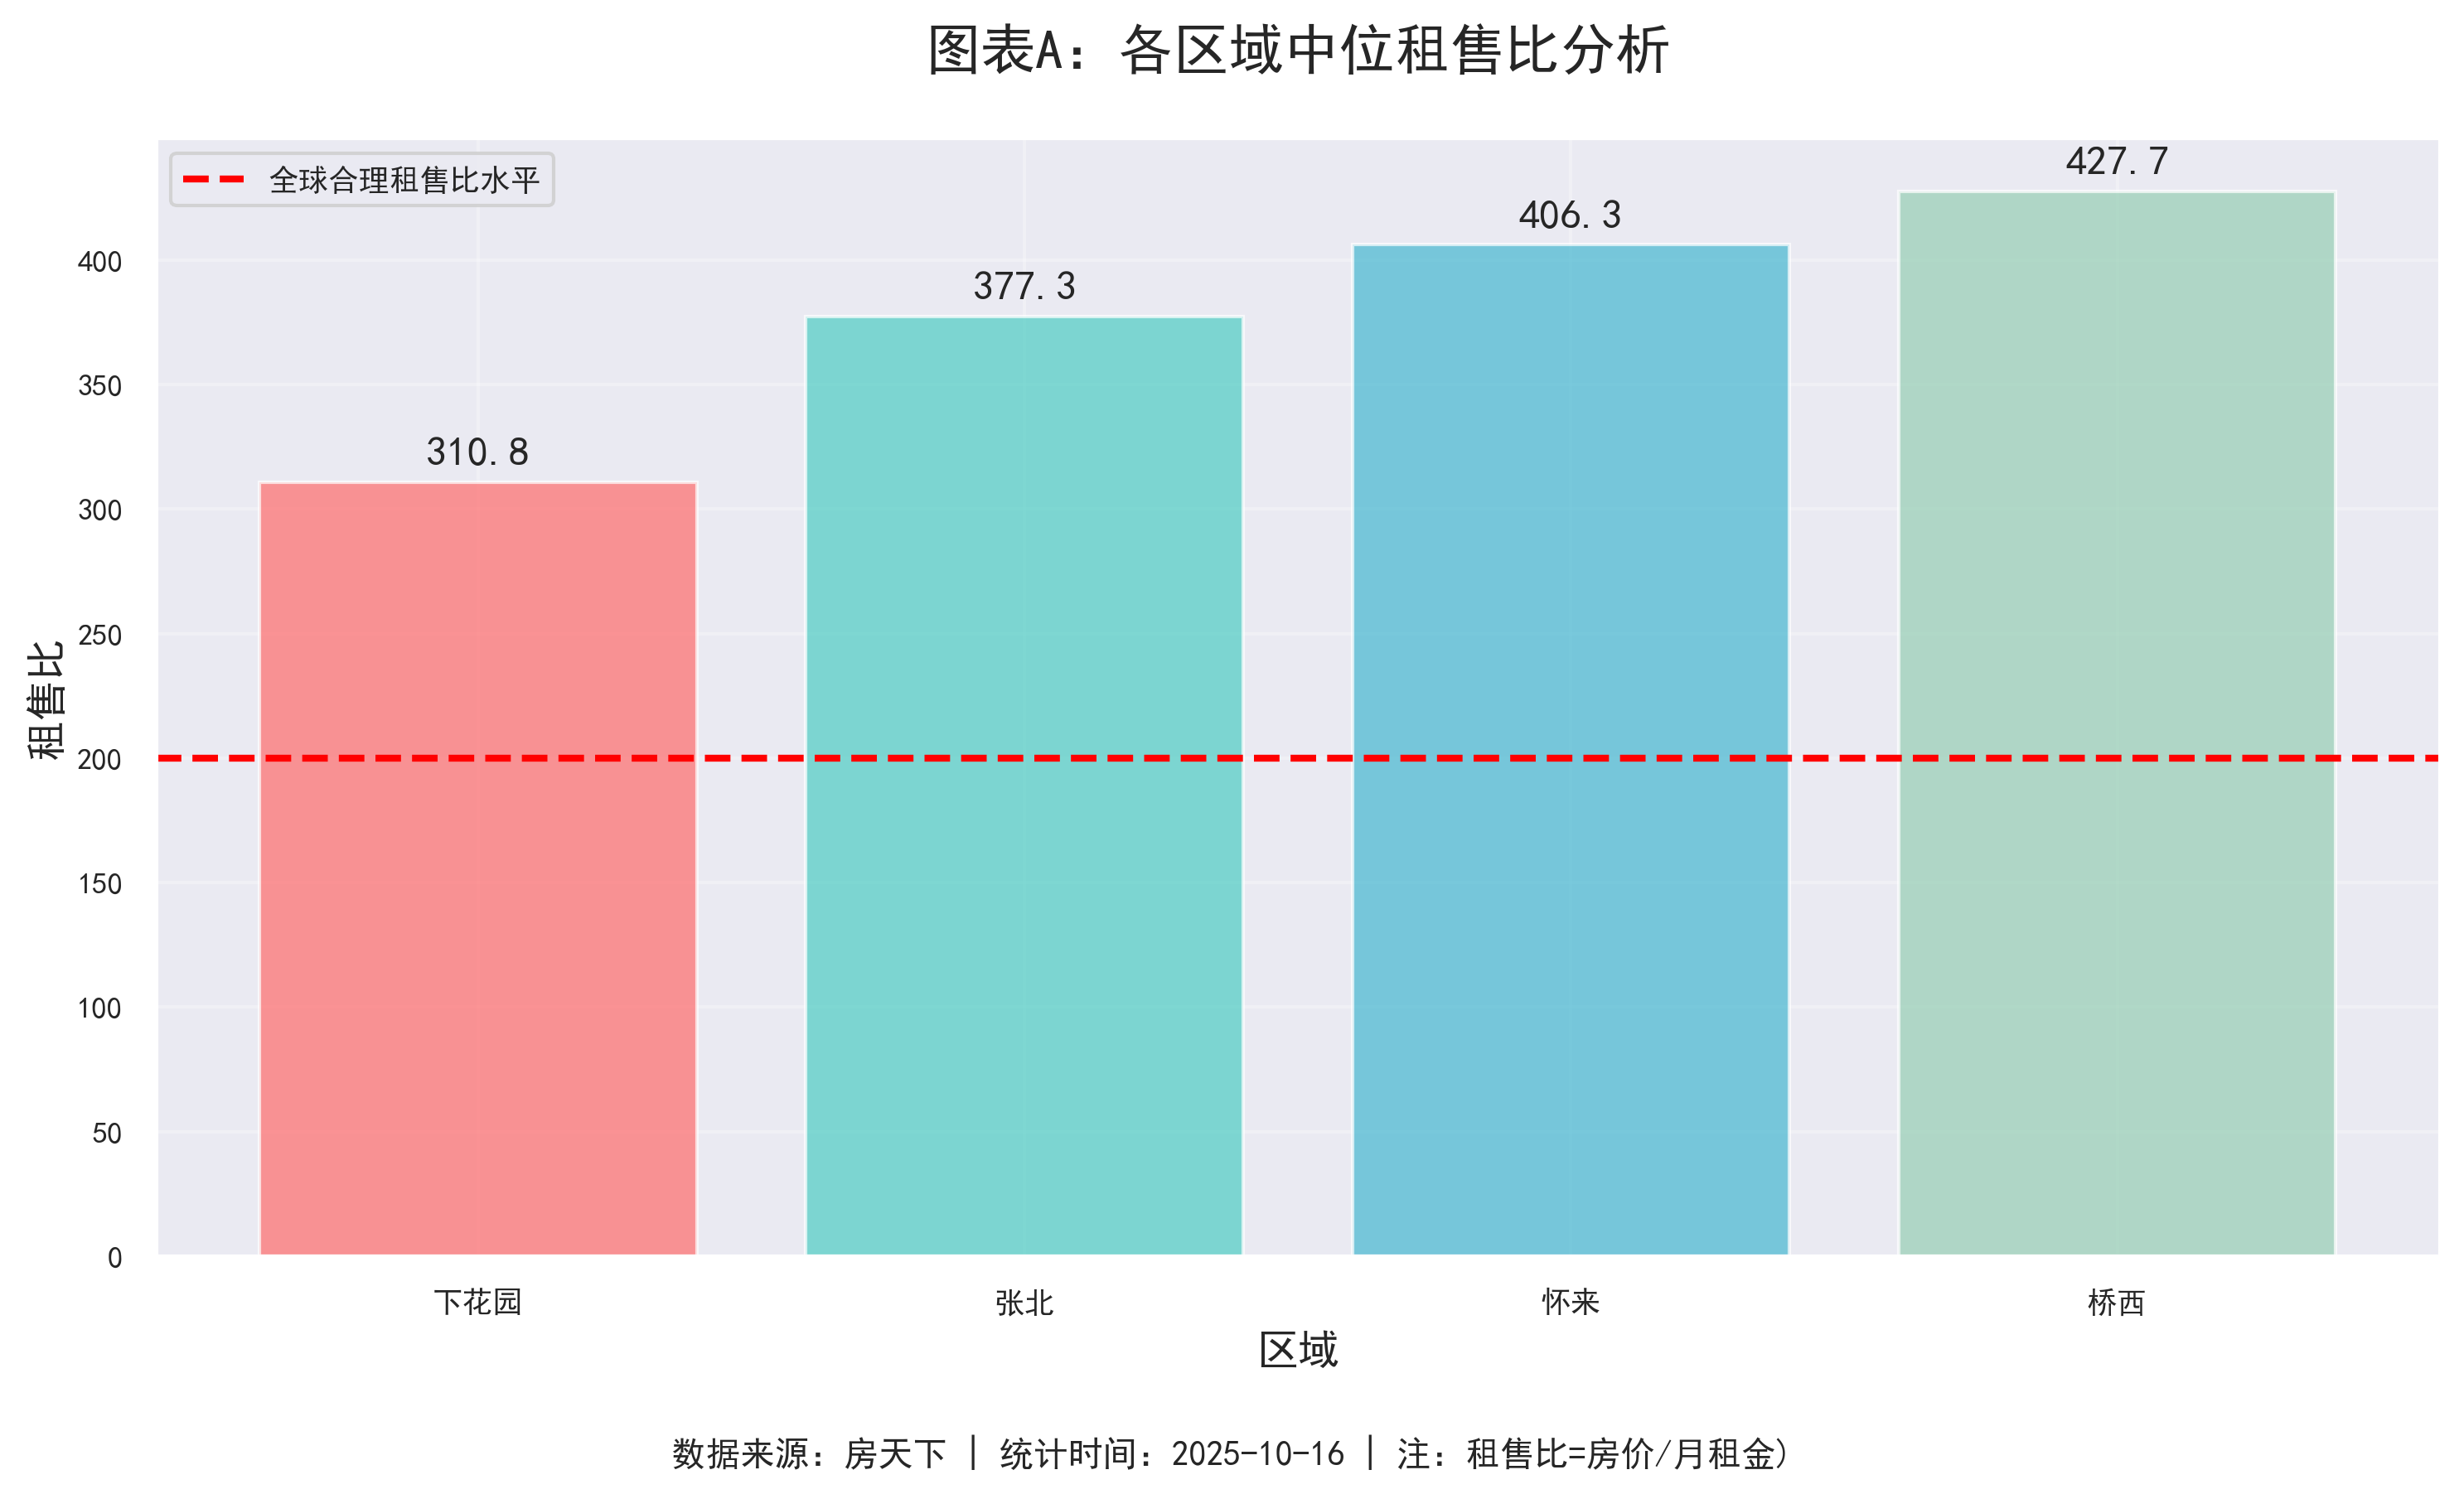

In [26]:
class DataAnalyzer:
    """数据分析类"""
    
    def __init__(self, data_manager):
        self.data_manager = data_manager
        self.ratio_data = None
        
    def calculate_descriptive_ratio(self):
        """计算描述性分析的租售比"""
        print("计算描述性分析租售比...")
        
        second_hand_df = self.data_manager.cleaned_second_hand
        rent_df = self.data_manager.cleaned_rent
        
        if second_hand_df.empty or rent_df.empty:
            print("警告：缺少二手房或租房数据")
            return None
        
        # 计算各区域的中位数价格和租金
        median_prices = second_hand_df.groupby('区域')['每平米房价'].median()
        median_rents = rent_df.groupby('区域')['每平米租金'].median()
        
        # 合并数据并计算租售比
        self.ratio_data = pd.DataFrame({
            '中位房价': median_prices,
            '中位租金': median_rents
        }).dropna()
        
        self.ratio_data['租售比'] = self.ratio_data['中位房价'] / (self.ratio_data['中位租金'])
        
        print("描述性分析租售比结果:")
        for area in self.ratio_data.index:
            data = self.ratio_data.loc[area]
            print(f"  {area}: {data['租售比']:.1f} (房价: {data['中位房价']:.0f}元/㎡, 租金: {data['中位租金']:.2f}元/㎡/月)")
        
        return self.ratio_data
    
    def create_rent_to_price_chart(self):
        """创建租售比图表 - 图表A"""
        if self.ratio_data is None or self.ratio_data.empty:
            print("无法创建图表：缺少租售比数据")
            return
        
        plt.rcParams['figure.dpi'] = 300 
        plt.figure(figsize=(10, 6))
        
        # 租售比柱状图
        bars = plt.bar(self.ratio_data.index, self.ratio_data['租售比'], 
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'],
                      alpha=0.7)
        
        # 添加合理水平线
        plt.axhline(y=200, color='red', linestyle='--', linewidth=2, 
                   label='全球合理租售比水平')
        
        # 在柱子上添加数值标签
        for bar, value in zip(bars, self.ratio_data['租售比']):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{value:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        plt.title('图表A：各区域中位租售比分析', fontsize=16, fontweight='bold', pad=20)
        plt.ylabel('租售比', fontsize=12)
        plt.xlabel('区域', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 添加数据说明
        plt.figtext(0.5, 0.01, 
                   f"数据来源：房天下 | 统计时间：{pd.Timestamp.now().strftime('%Y-%m-%d')} | 注：租售比=房价/月租金)", 
                   ha="center", fontsize=10, style='italic')
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        plt.show()
    
    def run_full_dataanalysis(self):
        """运行完整分析"""
        self.calculate_descriptive_ratio()
        self.create_rent_to_price_chart()

descriptive_analyzer = DataAnalyzer(data_manager)
descriptive_analyzer.run_full_dataanalysis()

 3-4: 基础线性建模
构建基础线性模型（3-4）...
房价基础模型 - 特征形状: (2925, 5), 标签形状: (2925,)
房价基础模型 - 测试集R²: 0.3147
租金基础模型 - 特征形状: (1032, 5), 标签形状: (1032,)
租金基础模型 - 测试集R²: 0.1654

计算基础模型租售比...
基础模型租售比:
  张北: 374.8
  桥西: 430.7
  下花园: 298.9
  怀来: 425.0


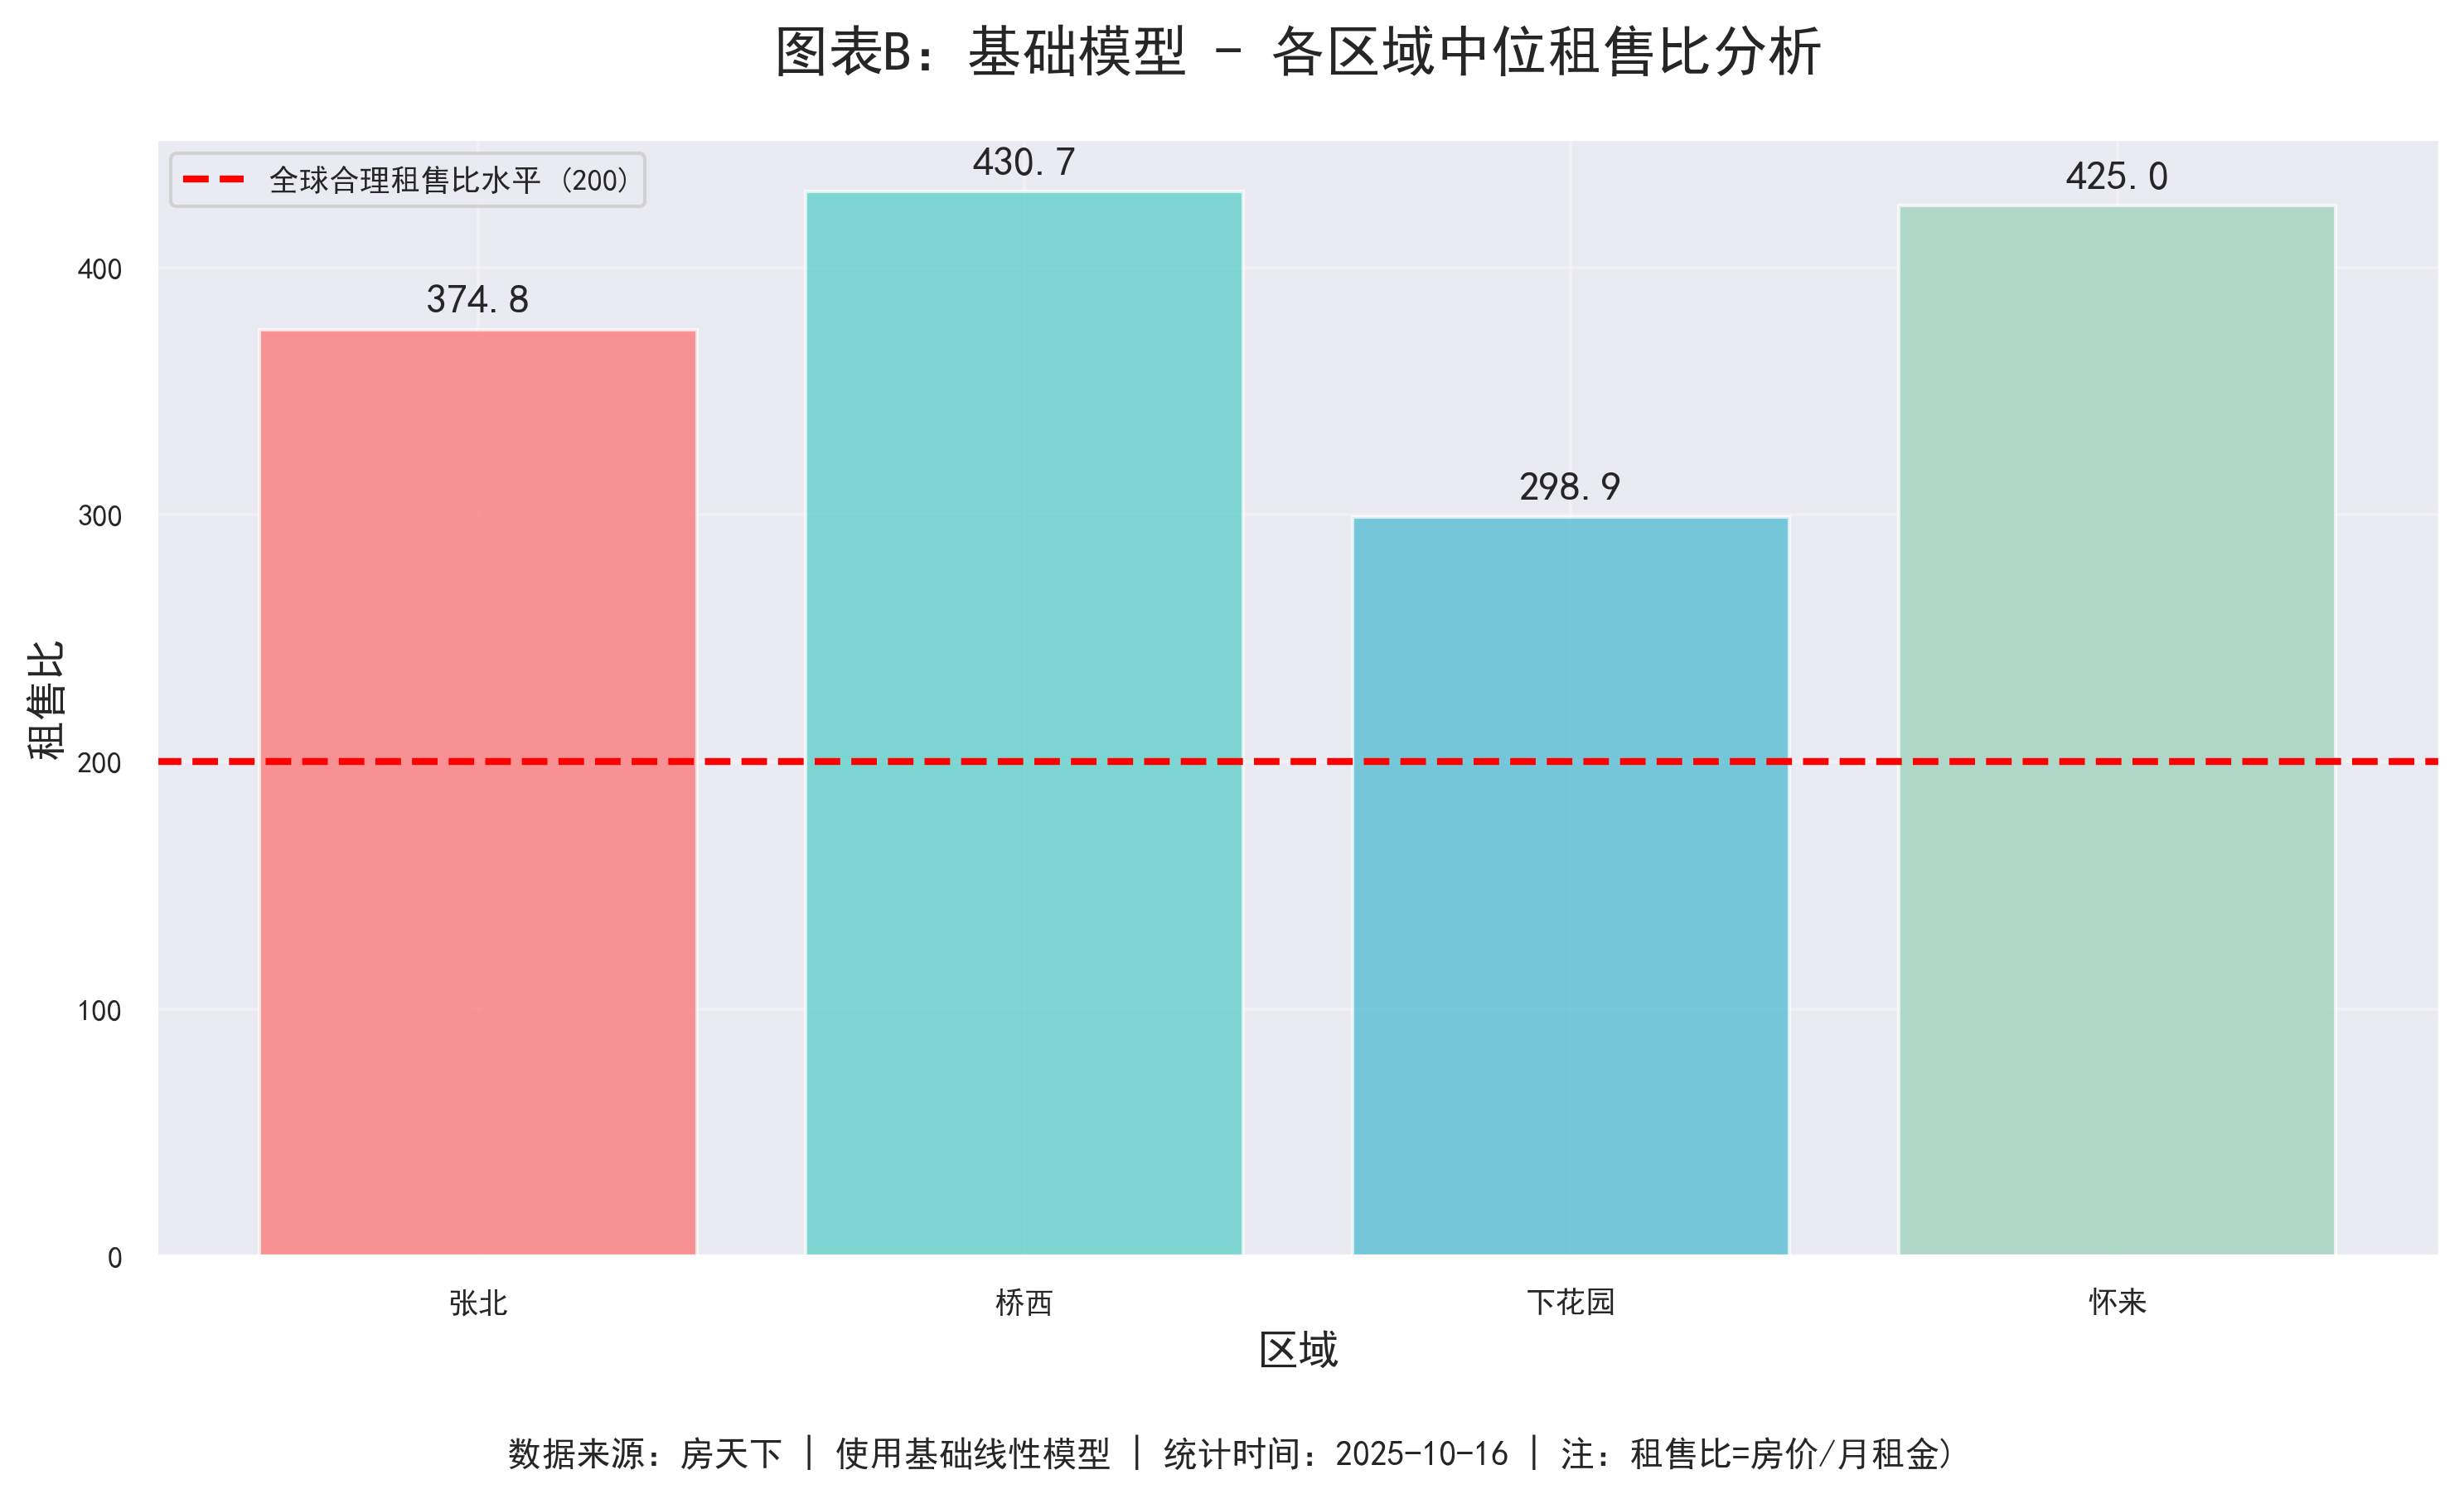

In [27]:
class HousingPriceModel:
    """房价预测模型类 - 对应 3-4"""
    
    def __init__(self, data_manager):
        self.data_manager = data_manager
        self.price_models = {}
        self.rent_models = {}
        
    def build_basic_models(self):
        """构建基础线性模型 - 3-4"""
        print("构建基础线性模型（3-4）...")
        
        # 直接使用清洗后的数据
        second_hand_df = self.data_manager.cleaned_second_hand.copy()
        rent_df = self.data_manager.cleaned_rent.copy()
        
        # 房价基础模型
        if not second_hand_df.empty and '建筑面积_㎡' in second_hand_df.columns:
            # 创建区域虚拟变量
            area_dummies = pd.get_dummies(second_hand_df['区域'], prefix='区域')
            second_hand_df = pd.concat([second_hand_df, area_dummies], axis=1)
            
            price_features = ['建筑面积_㎡'] + [col for col in second_hand_df.columns if col.startswith('区域_')]
            
            # 确保所有特征都存在
            available_features = [feat for feat in price_features if feat in second_hand_df.columns]
            
            if available_features:
                X_price = second_hand_df[available_features]
                y_price = second_hand_df['每平米房价']
                
                print(f"房价基础模型 - 特征形状: {X_price.shape}, 标签形状: {y_price.shape}")
                
                # 检查并处理NaN值
                valid_mask = ~(X_price.isna().any(axis=1) | y_price.isna())
                X_price_clean = X_price[valid_mask]
                y_price_clean = y_price[valid_mask]
                
                if len(X_price_clean) > 0:
                    # 分割数据
                    X_train, X_test, y_train, y_test = train_test_split(
                        X_price_clean, y_price_clean, test_size=0.2, random_state=42
                    )
                    
                    # 训练模型
                    price_model = LinearRegression()
                    price_model.fit(X_train, y_train)
                    
                    # 评估模型
                    y_pred_test = price_model.predict(X_test)
                    test_r2 = r2_score(y_test, y_pred_test)
                    
                    self.price_models = {
                        'model': price_model,
                        'test_r2': test_r2,
                        'coefficients': dict(zip(available_features, price_model.coef_)),
                        'intercept': price_model.intercept_
                    }
                    
                    # 保存预测结果
                    second_hand_df.loc[valid_mask, '基础模型预测房价'] = price_model.predict(X_price_clean)
                    print(f"房价基础模型 - 测试集R²: {test_r2:.4f}")
                else:
                    print("房价基础模型: 清洗后无有效数据")
            else:
                print("房价基础模型: 无可用特征")
        
        # 租金基础模型
        if not rent_df.empty and '面积_㎡' in rent_df.columns:
            # 创建区域虚拟变量
            area_dummies = pd.get_dummies(rent_df['区域'], prefix='区域')
            rent_df = pd.concat([rent_df, area_dummies], axis=1)
            
            rent_features = ['面积_㎡'] + [col for col in rent_df.columns if col.startswith('区域_')]
            
            # 确保所有特征都存在
            available_features = [feat for feat in rent_features if feat in rent_df.columns]
            
            if available_features:
                X_rent = rent_df[available_features]
                y_rent = rent_df['每平米租金']
                
                print(f"租金基础模型 - 特征形状: {X_rent.shape}, 标签形状: {y_rent.shape}")
                
                # 检查并处理NaN值
                valid_mask = ~(X_rent.isna().any(axis=1) | y_rent.isna())
                X_rent_clean = X_rent[valid_mask]
                y_rent_clean = y_rent[valid_mask]
                
                if len(X_rent_clean) > 0:
                    # 分割数据
                    X_train, X_test, y_train, y_test = train_test_split(
                        X_rent_clean, y_rent_clean, test_size=0.2, random_state=42
                    )
                    
                    # 训练模型
                    rent_model = LinearRegression()
                    rent_model.fit(X_train, y_train)
                    
                    # 评估模型
                    y_pred_test = rent_model.predict(X_test)
                    test_r2 = r2_score(y_test, y_pred_test)
                    
                    self.rent_models = {
                        'model': rent_model,
                        'test_r2': test_r2,
                        'coefficients': dict(zip(available_features, rent_model.coef_)),
                        'intercept': rent_model.intercept_
                    }
                    
                    # 保存预测结果
                    rent_df.loc[valid_mask, '基础模型预测租金'] = rent_model.predict(X_rent_clean)
                    print(f"租金基础模型 - 测试集R²: {test_r2:.4f}")
                else:
                    print("租金基础模型: 清洗后无有效数据")
            else:
                print("租金基础模型: 无可用特征")
        
        # 保存处理后的数据供后续使用
        self.second_hand_df_processed = second_hand_df
        self.rent_df_processed = rent_df
    
    def calculate_model_ratios(self):
        """计算基础模型的租售比"""
        print("\n计算基础模型租售比...")
        
        # 使用处理后的数据
        second_hand_df = getattr(self, 'second_hand_df_processed', self.data_manager.cleaned_second_hand)
        rent_df = getattr(self, 'rent_df_processed', self.data_manager.cleaned_rent)
        
        ratio_results = {}
        
        # 基础模型租售比
        if '基础模型预测房价' in second_hand_df.columns and '基础模型预测租金' in rent_df.columns:
            median_prices_basic = second_hand_df.groupby('区域')['基础模型预测房价'].median()
            median_rents_basic = rent_df.groupby('区域')['基础模型预测租金'].median()
            
            # 只计算共同存在的区域
            common_areas = set(median_prices_basic.index) & set(median_rents_basic.index)
            
            if common_areas:
                ratio_basic = pd.DataFrame({
                    '中位预测房价': median_prices_basic,
                    '中位预测租金': median_rents_basic
                }).loc[list(common_areas)].dropna()
                
                ratio_basic['租售比'] = ratio_basic['中位预测房价'] / (ratio_basic['中位预测租金'])
                ratio_results['basic'] = ratio_basic
                
                print("基础模型租售比:")
                for area in ratio_basic.index:
                    data = ratio_basic.loc[area]
                    print(f"  {area}: {data['租售比']:.1f}")
            else:
                print("基础模型: 没有共同的区域数据计算租售比")
        
        return ratio_results
    
    @staticmethod
    def plot_chartB(ratio_data):
        """绘制图表B：基础模型租售比分析"""
        if ratio_data is None or ratio_data.empty:
            print("无法创建图表B：缺少基础模型数据")
            return
        
        plt.rcParams['figure.dpi'] = 300 
        plt.figure(figsize=(10, 6))
        
        # 租售比柱状图
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
        bars = plt.bar(ratio_data.index, ratio_data['租售比'], 
                    color=colors[:len(ratio_data)], alpha=0.7)
        
        # 添加合理水平线
        plt.axhline(y=200, color='red', linestyle='--', linewidth=2, 
                label='全球合理租售比水平 (200)')
        
        # 在柱子上添加数值标签
        for bar, value in zip(bars, ratio_data['租售比']):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{value:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        plt.title('图表B：基础模型 - 各区域中位租售比分析', fontsize=16, fontweight='bold', pad=20)
        plt.ylabel('租售比', fontsize=12)
        plt.xlabel('区域', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 添加数据说明
        plt.figtext(0.5, 0.01, 
                f"数据来源：房天下 | 使用基础线性模型 | 统计时间：{pd.Timestamp.now().strftime('%Y-%m-%d')} | 注：租售比=房价/月租金)", 
                ha="center", fontsize=10, style='italic')
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        plt.show()

    def run_basic_analysis(self):
        """运行完整的基础建模分析流程"""
        print(" 3-4: 基础线性建模")
        
        # 构建基础模型
        self.build_basic_models()
        
        # 计算租售比
        basic_ratio_results = self.calculate_model_ratios()

        # 绘制图表B
        self.plot_chartB(basic_ratio_results['basic'])
        
        return basic_ratio_results

#  3-4: 基础建模分析
price_model = HousingPriceModel(data_manager)
basic_ratio_results = price_model.run_basic_analysis()

 进阶进阶建模分析（3-5）...
构建 进阶版房价模型...
 进阶房价模型 - 特征数量: 8
特征列表: ['建筑面积_㎡_对数', '建筑面积_㎡_标准化', '区域_张北', '区域_怀来', '区域_桥西', '建筑面积_㎡_标准化_x_区域_张北', '建筑面积_㎡_标准化_x_区域_怀来', '建筑面积_㎡_标准化_x_区域_桥西']
 进阶房价模型 - 训练集R²: 0.3421, MAE: 1649.73
 进阶房价模型 - 测试集R²: 0.3521, MAE: 1676.57
 进阶房价模型 - 特征数量: 8
构建 进阶版租金模型...
 进阶租金模型 - 特征数量: 8
特征列表: ['面积_㎡_对数', '面积_㎡_标准化', '区域_张北', '区域_怀来', '区域_桥西', '面积_㎡_标准化_x_区域_张北', '面积_㎡_标准化_x_区域_怀来', '面积_㎡_标准化_x_区域_桥西']
 进阶租金模型 - 训练集R²: 0.3106, MAE: 2.29
 进阶租金模型 - 测试集R²: 0.2176, MAE: 2.40
 进阶租金模型 - 特征数量: 8

 进阶模型特征重要性分析:
房价模型特征系数 (标准化后):
  区域_怀来: +2942.27 ***
  区域_桥西: +2106.25 ***
  建筑面积_㎡_对数: +2090.80 ***
  建筑面积_㎡_标准化_x_区域_怀来: +1233.10 ***
  建筑面积_㎡_标准化: -844.73 **
  区域_张北: +540.98 **
  建筑面积_㎡_标准化_x_区域_桥西: -406.08 *
  建筑面积_㎡_标准化_x_区域_张北: +26.25 

房价模型 - 截距项: -6025.98

租金模型特征系数 (标准化后):
  面积_㎡_对数: -9.32 **
  区域_怀来: +4.89 *
  区域_桥西: +3.07 *
  区域_张北: +1.44 *
  面积_㎡_标准化: +1.09 *
  面积_㎡_标准化_x_区域_怀来: +0.91 
  面积_㎡_标准化_x_区域_桥西: +0.80 
  面积_㎡_标准化_x_区域_张北: +0.34 

租金模型 - 截距项: 51.22

模型性能对比:
房价模型:
  

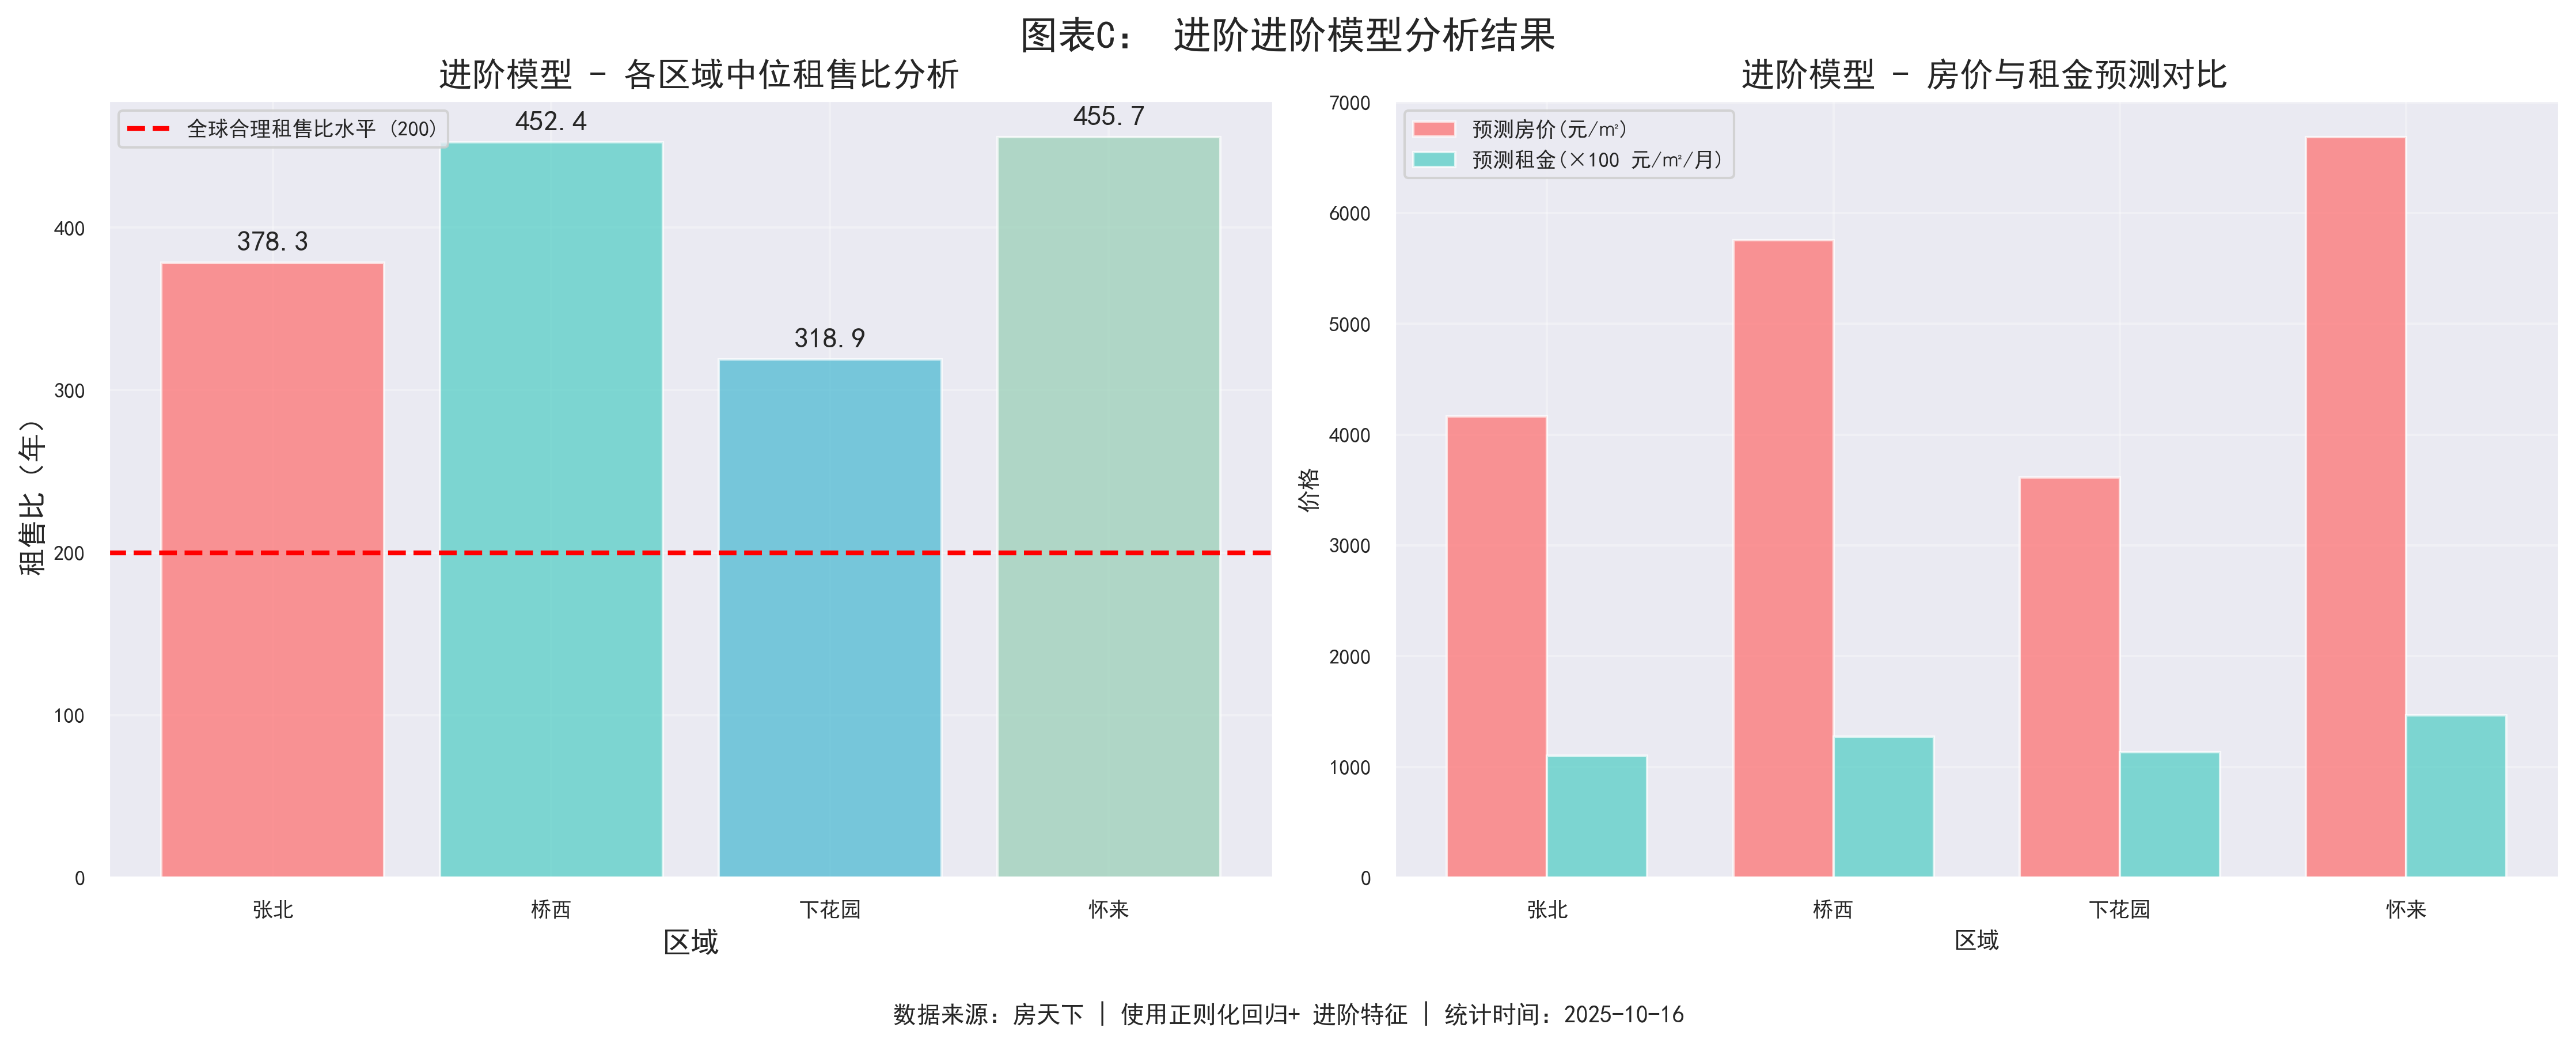

In [28]:
class AdvancedHousingModel:
    """
    高级住房模型类，用于构建和分析房价与租金的优化预测模型
    
    功能包括：
    - 创建优化特征（对数转换、标准化、区域编码、交互特征）
    - 构建房价和租金的正则化回归模型
    - 分析特征重要性和模型性能
    - 计算和可视化租售比
    """
    
    def __init__(self, data_manager):
        """
        初始化模型类
        
        参数:
            data_manager: 数据管理器对象，包含清洗后的住房数据
        """
        self.data_manager = data_manager  # 数据管理器，用于获取清洗后的数据
        self.advanced_price_models = {}   # 存储房价模型及相关信息
        self.advanced_rent_models = {}    # 存储租金模型及相关信息
        self.scalers = {}                 # 存储特征缩放器，用于后续数据转换
    
    def create_optimized_features(self, df, target_type='price'):
        """
        为模型创建优化特征集，包括特征转换、标准化和交互特征
        
        参数:
            df: 原始数据DataFrame
            target_type: 目标类型，'price'表示房价模型，'rent'表示租金模型
        
        返回:
            df_optimized: 包含优化特征的DataFrame
        """
        # 复制原始数据，避免修改源数据
        df_optimized = df.copy()
        
        # 根据目标类型选择对应的面积列
        if target_type == 'price':
            area_col = '建筑面积_㎡'
        else:
            area_col = '面积_㎡'
        
        # 对面积进行对数转换，缓解数据偏度
        df_optimized[f'{area_col}_对数'] = np.log1p(df_optimized[area_col])
        
        # 对面积进行标准化处理，使模型更稳定
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        df_optimized[f'{area_col}_标准化'] = scaler.fit_transform(df_optimized[[area_col]])
        # 保存缩放器，用于后续新数据的转换
        self.scalers[f'{target_type}_area'] = scaler
        
        # 对区域特征进行独热编码，处理类别型变量
        area_dummies = pd.get_dummies(df_optimized['区域'], prefix='区域', drop_first=True)
        df_optimized = pd.concat([df_optimized, area_dummies], axis=1)
        
        # 创建面积与区域的交互特征，捕捉区域对面积影响的差异性
        area_columns = [col for col in df_optimized.columns if col.startswith('区域_')]
        for area_col_dummy in area_columns:
            interaction_name = f'{area_col}_标准化_x_{area_col_dummy}'
            df_optimized[interaction_name] = df_optimized[f'{area_col}_标准化'] * df_optimized[area_col_dummy]
        
        return df_optimized
    
    def build_optimized_price_model(self):
        """
        构建优化的房价预测模型（使用Ridge回归）
        
        返回:
            df_optimized: 包含预测结果的特征数据集
        """
        print("构建 进阶版房价模型...")
        
        # 获取清洗后的二手房数据
        second_hand_df = self.data_manager.cleaned_second_hand.copy()
        
        # 检查数据是否充足且包含必要特征
        if second_hand_df.empty or '建筑面积_㎡' not in second_hand_df.columns:
            print("房价模型: 数据不足或特征缺失")
            return
        
        # 创建优化特征集
        df_optimized = self.create_optimized_features(second_hand_df, 'price')
        
        # 定义模型使用的特征集：基础特征+区域特征+交互特征
        base_features = ['建筑面积_㎡_对数', '建筑面积_㎡_标准化']
        area_features = [col for col in df_optimized.columns if col.startswith('区域_')]
        interaction_features = [col for col in df_optimized.columns if '_标准化_x_' in col]
        all_features = base_features + area_features + interaction_features
        
        # 筛选实际存在的特征
        available_features = [feat for feat in all_features if feat in df_optimized.columns]
        
        # 检查特征数量是否满足模型要求
        if len(available_features) < 3:
            print("房价模型: 特征数量不足")
            return
        
        # 定义特征矩阵X和目标变量y
        X = df_optimized[available_features]
        y = df_optimized['每平米房价']
        
        # 数据清洗：过滤缺失值和无效值（价格必须大于0）
        valid_mask = (~X.isna().any(axis=1)) & (~y.isna()) & (y > 0)
        X_clean = X[valid_mask]
        y_clean = y[valid_mask]
        
        # 检查清洗后的样本量是否足够
        if len(X_clean) < 20:
            print("房价模型: 清洗后样本数量不足")
            return
        
        # 打印模型构建信息
        print(f" 进阶房价模型 - 特征数量: {len(available_features)}")
        print(f"特征列表: {available_features}")
        
        # 分割训练集和测试集（8:2比例）
        X_train, X_test, y_train, y_test = train_test_split(
            X_clean, y_clean, test_size=0.2, random_state=42
        )
        
        # 使用Ridge回归（带L2正则化）构建模型，防止过拟合
        from sklearn.linear_model import Ridge
        model = Ridge(alpha=1.0, random_state=42)
        
        # 训练模型
        model.fit(X_train, y_train)
        
        # 在训练集和测试集上进行预测
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # 计算模型评估指标（R²和MAE）
        train_r2 = r2_score(y_train, y_pred_train)  # 决定系数，越接近1越好
        test_r2 = r2_score(y_test, y_pred_test)
        train_mae = mean_absolute_error(y_train, y_pred_train)  # 平均绝对误差，越小越好
        test_mae = mean_absolute_error(y_test, y_pred_test)
        
        # 保存模型及相关信息
        self.advanced_price_models = {
            'model': model,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'features': available_features,
            'coefficients': dict(zip(available_features, model.coef_)),  # 特征系数（重要性）
            'intercept': model.intercept_,  # 截距项
            'feature_data': df_optimized
        }
        
        # 将预测结果添加到数据集中
        df_optimized.loc[valid_mask, ' 进阶模型预测房价'] = model.predict(X_clean)
        
        # 打印模型评估结果
        print(f" 进阶房价模型 - 训练集R²: {train_r2:.4f}, MAE: {train_mae:.2f}")
        print(f" 进阶房价模型 - 测试集R²: {test_r2:.4f}, MAE: {test_mae:.2f}")
        print(f" 进阶房价模型 - 特征数量: {len(available_features)}")
        
        return df_optimized
    
    def build_optimized_rent_model(self):
        """
        构建优化的租金预测模型（使用Ridge回归），流程与房价模型类似
        
        返回:
            df_optimized: 包含预测结果的特征数据集
        """
        print("构建 进阶版租金模型...")
        
        # 获取清洗后的租金数据
        rent_df = self.data_manager.cleaned_rent.copy()
        
        # 检查数据是否充足且包含必要特征
        if rent_df.empty or '面积_㎡' not in rent_df.columns:
            print("租金模型: 数据不足或特征缺失")
            return
        
        # 创建优化特征集
        df_optimized = self.create_optimized_features(rent_df, 'rent')
        
        # 定义模型使用的特征集
        base_features = ['面积_㎡_对数', '面积_㎡_标准化']
        area_features = [col for col in df_optimized.columns if col.startswith('区域_')]
        interaction_features = [col for col in df_optimized.columns if '_标准化_x_' in col]
        all_features = base_features + area_features + interaction_features
        
        # 筛选实际存在的特征
        available_features = [feat for feat in all_features if feat in df_optimized.columns]
        
        # 检查特征数量是否满足模型要求
        if len(available_features) < 3:
            print("租金模型: 特征数量不足")
            return
        
        # 定义特征矩阵X和目标变量y
        X = df_optimized[available_features]
        y = df_optimized['每平米租金']
        
        # 数据清洗：过滤缺失值和无效值（租金必须大于0）
        valid_mask = (~X.isna().any(axis=1)) & (~y.isna()) & (y > 0)
        X_clean = X[valid_mask]
        y_clean = y[valid_mask]
        
        # 检查清洗后的样本量是否足够
        if len(X_clean) < 20:
            print("租金模型: 清洗后样本数量不足")
            return
        
        # 打印模型构建信息
        print(f" 进阶租金模型 - 特征数量: {len(available_features)}")
        print(f"特征列表: {available_features}")
        
        # 分割训练集和测试集（8:2比例）
        X_train, X_test, y_train, y_test = train_test_split(
            X_clean, y_clean, test_size=0.2, random_state=42
        )
        
        # 使用Ridge回归构建模型
        from sklearn.linear_model import Ridge
        model = Ridge(alpha=1.0, random_state=42)
        
        # 训练模型
        model.fit(X_train, y_train)
        
        # 在训练集和测试集上进行预测
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # 计算模型评估指标
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        
        # 保存模型及相关信息
        self.advanced_rent_models = {
            'model': model,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'features': available_features,
            'coefficients': dict(zip(available_features, model.coef_)),
            'intercept': model.intercept_,
            'feature_data': df_optimized
        }
        
        # 将预测结果添加到数据集中
        df_optimized.loc[valid_mask, ' 进阶模型预测租金'] = model.predict(X_clean)
        
        # 打印模型评估结果
        print(f" 进阶租金模型 - 训练集R²: {train_r2:.4f}, MAE: {train_mae:.2f}")
        print(f" 进阶租金模型 - 测试集R²: {test_r2:.4f}, MAE: {test_mae:.2f}")
        print(f" 进阶租金模型 - 特征数量: {len(available_features)}")
        
        return df_optimized
    
    def analyze_feature_importance(self):
        """分析并打印模型中各特征的重要性（基于回归系数）"""
        print("\n 进阶模型特征重要性分析:")
        print("=" * 50)
        
        # 分析房价模型的特征系数
        if self.advanced_price_models:
            print("房价模型特征系数 (标准化后):")
            coef_dict = self.advanced_price_models['coefficients']
            # 按系数绝对值排序，从大到小
            for feature, coef in sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True):
                # 根据系数绝对值标记显著性（自定义阈值）
                significance = "***" if abs(coef) > 1000 else "**" if abs(coef) > 500 else "*" if abs(coef) > 100 else ""
                print(f"  {feature}: {coef:+.2f} {significance}")
            
            print(f"\n房价模型 - 截距项: {self.advanced_price_models['intercept']:.2f}")
        
        # 分析租金模型的特征系数
        if self.advanced_rent_models:
            print("\n租金模型特征系数 (标准化后):")
            coef_dict = self.advanced_rent_models['coefficients']
            # 按系数绝对值排序，从大到小
            for feature, coef in sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True):
                # 根据系数绝对值标记显著性（自定义阈值）
                significance = "***" if abs(coef) > 10 else "**" if abs(coef) > 5 else "*" if abs(coef) > 1 else ""
                print(f"  {feature}: {coef:+.2f} {significance}")
            
            print(f"\n租金模型 - 截距项: {self.advanced_rent_models['intercept']:.2f}")
    
    def calculate_optimized_ratios(self):
        """
        计算各区域的租售比（房价/年租金）
        
        返回:
            ratio_data: 包含各区域租售比数据的DataFrame
        """
        print("\n计算 进阶模型租售比...")
        
        # 检查模型是否已训练
        if not self.advanced_price_models or not self.advanced_rent_models:
            print("警告： 进阶模型未训练完成")
            return None
        
        # 获取包含预测结果的数据集
        price_df = self.advanced_price_models['feature_data']
        rent_df = self.advanced_rent_models['feature_data']
        
        # 检查是否包含预测结果
        if ' 进阶模型预测房价' not in price_df.columns or ' 进阶模型预测租金' not in rent_df.columns:
            print("警告：缺少预测结果")
            return None
        
        # 计算各区域的中位预测房价和租金
        median_prices = price_df.groupby('区域')[' 进阶模型预测房价'].median()
        median_rents = rent_df.groupby('区域')[' 进阶模型预测租金'].median()
        
        # 找到同时存在房价和租金数据的区域
        common_areas = set(median_prices.index) & set(median_rents.index)
        
        if not common_areas:
            print("警告：没有共同的区域数据")
            return None
        
        # 构建租售比数据集
        ratio_data = pd.DataFrame({
            '中位预测房价': median_prices,
            '中位预测租金': median_rents
        }).loc[list(common_areas)].dropna()
        
        # 计算租售比（房价 / 月租金)）
        ratio_data['租售比'] = ratio_data['中位预测房价'] / (ratio_data['中位预测租金'])
        
        # 打印租售比结果
        print(" 进阶模型租售比结果:")
        for area in ratio_data.index:
            data = ratio_data.loc[area]
            print(f"  {area}: {data['租售比']:.1f}年 (房价: {data['中位预测房价']:.0f}元/㎡, 租金: {data['中位预测租金']:.2f}元/㎡/月)")
        
        return ratio_data
    
    def plot_optimized_results(self, ratio_data):
        """
        可视化租售比结果
        
        参数:
            ratio_data: 包含租售比数据的DataFrame
        """
        if ratio_data is None or ratio_data.empty:
            print("无法创建图表：缺少 进阶模型结果")
            return
        
        # 创建1行2列的图表
        plt.rcParams['figure.dpi'] = 300 
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # 第一幅图：各区域租售比柱状图
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
        bars = ax1.bar(ratio_data.index, ratio_data['租售比'],
                      color=colors[:len(ratio_data)], alpha=0.7)
        
        # 添加参考线（全球合理租售比水平）
        ax1.axhline(y=200, color='red', linestyle='--', linewidth=2,
                   label='全球合理租售比水平 (200)')
        
        # 在柱状图上添加数值标签
        for bar, value in zip(bars, ratio_data['租售比']):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{value:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        # 设置图表标题和标签
        ax1.set_title(' 进阶模型 - 各区域中位租售比分析', fontsize=14, fontweight='bold')
        ax1.set_ylabel('租售比（年）', fontsize=12)
        ax1.set_xlabel('区域', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 第二幅图：房价与租金对比图
        x = np.arange(len(ratio_data.index))
        width = 0.35
        
        # 绘制房价和租金柱状图（租金放大100倍便于对比）
        ax2.bar(x - width/2, ratio_data['中位预测房价'], width, 
               label='预测房价(元/㎡)', color='#FF6B6B', alpha=0.7)
        ax2.bar(x + width/2, ratio_data['中位预测租金'] * 100, width, 
               label='预测租金(×100 元/㎡/月)', color='#4ECDC4', alpha=0.7)
        
        # 设置图表标题和标签
        ax2.set_xlabel('区域')
        ax2.set_ylabel('价格')
        ax2.set_title(' 进阶模型 - 房价与租金预测对比', fontsize=14, fontweight='bold')
        ax2.set_xticks(x)
        ax2.set_xticklabels(ratio_data.index)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 设置整体标题和数据来源说明
        plt.suptitle('图表C： 进阶进阶模型分析结果', fontsize=16, fontweight='bold')
        plt.figtext(0.5, 0.01,
                   f"数据来源：房天下 | 使用正则化回归+ 进阶特征 | 统计时间：{pd.Timestamp.now().strftime('%Y-%m-%d')}",
                   ha="center", fontsize=10, style='italic')
        
        # 调整布局并显示图表
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15, top=0.9)
        plt.show()
    
    def compare_model_performance(self):
        """对比并打印房价模型和租金模型的性能指标"""
        print("\n模型性能对比:")
        print("=" * 40)
        
        # 打印房价模型性能指标
        if self.advanced_price_models:
            print("房价模型:")
            print(f"  R² (训练集): {self.advanced_price_models['train_r2']:.4f}")  # 越接近1越好
            print(f"  R² (测试集): {self.advanced_price_models['test_r2']:.4f}")
            print(f"  MAE (训练集): {self.advanced_price_models['train_mae']:.2f} 元/㎡")  # 越小越好
            print(f"  MAE (测试集): {self.advanced_price_models['test_mae']:.2f} 元/㎡")
        
        # 打印租金模型性能指标
        if self.advanced_rent_models:
            print("\n租金模型:")
            print(f"  R² (训练集): {self.advanced_rent_models['train_r2']:.4f}")
            print(f"  R² (测试集): {self.advanced_rent_models['test_r2']:.4f}")
            print(f"  MAE (训练集): {self.advanced_rent_models['train_mae']:.2f} 元/㎡")
            print(f"  MAE (测试集): {self.advanced_rent_models['test_mae']:.2f} 元/㎡")
    
    def run_optimized_analysis(self):
        """
        执行完整的优化分析流程
        
        返回:
            ratio_data: 租售比分析结果
        """
        print(" 进阶进阶建模分析（3-5）...")
        print("=" * 60)
        
        # 依次执行模型构建、特征分析、性能对比、租售比计算和可视化
        price_df = self.build_optimized_price_model()
        rent_df = self.build_optimized_rent_model()
        
        self.analyze_feature_importance()
        
        self.compare_model_performance()
        
        ratio_data = self.calculate_optimized_ratios()
        
        if ratio_data is not None:
            self.plot_optimized_results(ratio_data)
        
        return ratio_data


optimized_model = AdvancedHousingModel(data_manager)
optimized_ratio_data = optimized_model.run_optimized_analysis()


3-6: 三种方法租售比对比分析
收集三种方法的租售比数据...

计算基础模型租售比...
基础模型租售比:
  张北: 374.8
  桥西: 430.7
  下花园: 298.9
  怀来: 425.0

计算 进阶模型租售比...
 进阶模型租售比结果:
  张北: 378.3年 (房价: 4166元/㎡, 租金: 11.01元/㎡/月)
  桥西: 452.4年 (房价: 5758元/㎡, 租金: 12.73元/㎡/月)
  下花园: 318.9年 (房价: 3612元/㎡, 租金: 11.33元/㎡/月)
  怀来: 455.7年 (房价: 6686元/㎡, 租金: 14.67元/㎡/月)

三种方法租售比结果汇总:
     二手房样本量  租房样本量    总样本量  描述性分析租售比  基础模型租售比  进阶模型租售比
下花园   437.0  154.0   591.0     310.8    298.9    318.9
张北    162.0   68.0   230.0     377.3    374.8    378.3
怀来   1158.0   69.0  1227.0     406.3    425.0    455.7
桥西   1168.0  741.0  1909.0     427.7    430.7    452.4

基于样本量的可靠性分析:
下花园:
  总样本量: 591.0 (二手房: 437.0, 租房: 154.0)
  可靠性: 高 | 样本不平衡
  推荐方法: 进阶模型 (样本充足，模型更精确)
张北:
  总样本量: 230.0 (二手房: 162.0, 租房: 68.0)
  可靠性: 高 | 样本不平衡
  推荐方法: 进阶模型 (样本充足，模型更精确)
怀来:
  总样本量: 1227.0 (二手房: 1158.0, 租房: 69.0)
  可靠性: 高 | 样本不平衡
  推荐方法: 进阶模型 (样本充足，模型更精确)
桥西:
  总样本量: 1909.0 (二手房: 1168.0, 租房: 741.0)
  可靠性: 高 | 样本平衡
  推荐方法: 进阶模型 (样本充足，模型更精确)

方法一致性分析:
方法间相关系数矩阵:
          描述性分析租售比  基础模型租售比  

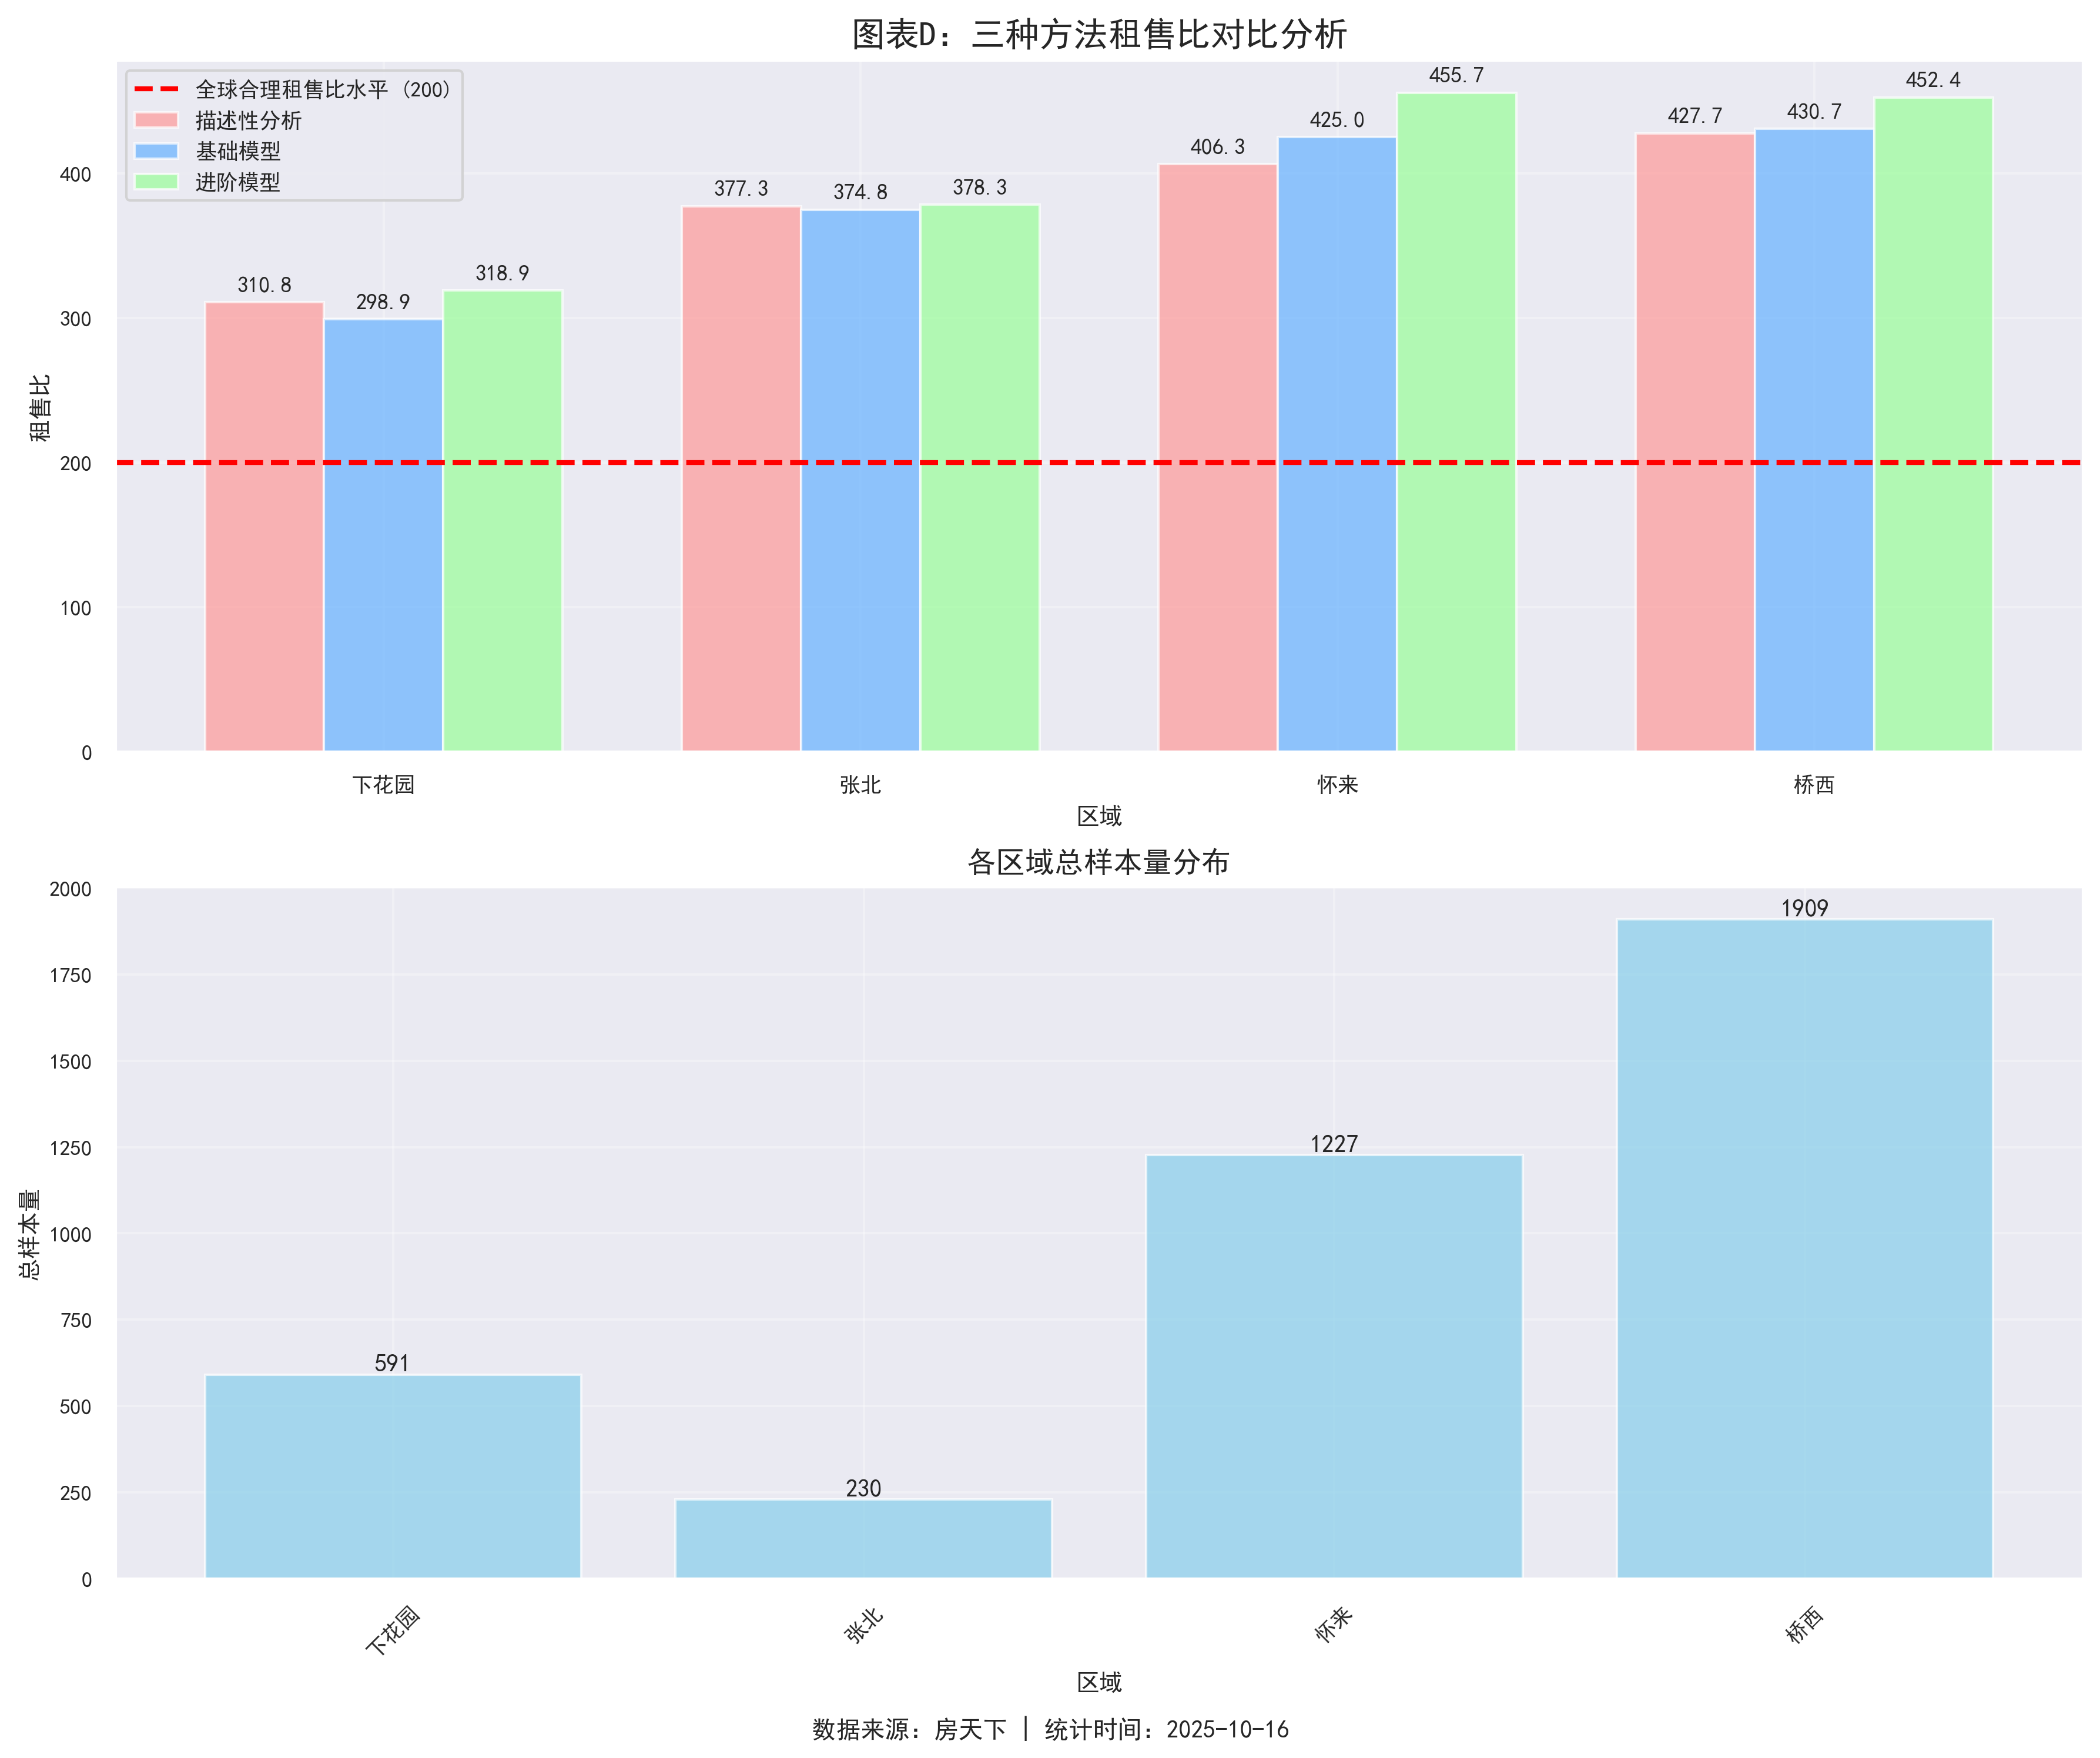


基于样本量的方法推荐:

基于样本量的可靠性分析:
下花园:
  总样本量: 591.0 (二手房: 437.0, 租房: 154.0)
  可靠性: 高 | 样本不平衡
  推荐方法: 进阶模型 (样本充足，模型更精确)
张北:
  总样本量: 230.0 (二手房: 162.0, 租房: 68.0)
  可靠性: 高 | 样本不平衡
  推荐方法: 进阶模型 (样本充足，模型更精确)
怀来:
  总样本量: 1227.0 (二手房: 1158.0, 租房: 69.0)
  可靠性: 高 | 样本不平衡
  推荐方法: 进阶模型 (样本充足，模型更精确)
桥西:
  总样本量: 1909.0 (二手房: 1168.0, 租房: 741.0)
  可靠性: 高 | 样本平衡
  推荐方法: 进阶模型 (样本充足，模型更精确)

总体建议:
1. 样本量 > 100: 信任进阶模型，它考虑了更多特征且更精确
2. 样本量 50-100: 信任基础模型，平衡了精确性和稳定性
3. 样本量 < 50: 信任描述性分析，简单方法在样本少时更稳定
4. 样本不平衡时(二手房/租房比例<0.5): 谨慎解释结果

各区域具体建议:
  下花园 (样本量: 591.0): 进阶模型 (样本充足，模型更精确)
  张北 (样本量: 230.0): 进阶模型 (样本充足，模型更精确)
  怀来 (样本量: 1227.0): 进阶模型 (样本充足，模型更精确)
  桥西 (样本量: 1909.0): 进阶模型 (样本充足，模型更精确)


In [29]:
# %%
#%% 3-6: 三种方法租售比对比分析
class RatioComparisonAnalyzer:
    """租售比对比分析类 - 对应 3-6"""
    
    def __init__(self, data_manager, descriptive_analyzer, basic_model, advanced_model):
        """
        初始化对比分析器
        
        参数:
            data_manager: 数据管理器对象
            descriptive_analyzer: 描述性分析器对象
            basic_model: 基础模型对象
            advanced_model: 进阶模型对象
        """
        self.data_manager = data_manager
        self.descriptive_analyzer = descriptive_analyzer
        self.basic_model = basic_model
        self.advanced_model = advanced_model
        self.comparison_data = None
    
    def collect_ratio_data(self):
        """收集三种方法的租售比数据"""
        print("收集三种方法的租售比数据...")
        
        # 获取各区域的样本量
        second_hand_counts = self.data_manager.cleaned_second_hand['区域'].value_counts()
        rent_counts = self.data_manager.cleaned_rent['区域'].value_counts()
        
        # 收集描述性分析的租售比
        descriptive_ratios = self.descriptive_analyzer.ratio_data['租售比']
        
        # 收集基础模型的租售比
        basic_ratio_results = self.basic_model.calculate_model_ratios()
        basic_ratios = basic_ratio_results['basic']['租售比'] if 'basic' in basic_ratio_results else None
        
        # 收集进阶模型的租售比
        advanced_ratios_data = self.advanced_model.calculate_optimized_ratios()
        advanced_ratios = advanced_ratios_data['租售比'] if advanced_ratios_data is not None else None
        
        # 构建对比数据
        comparison_data = {}
        
        # 获取所有区域的并集
        all_areas = set(descriptive_ratios.index)
        if basic_ratios is not None:
            all_areas = all_areas.union(set(basic_ratios.index))
        if advanced_ratios is not None:
            all_areas = all_areas.union(set(advanced_ratios.index))
        
        for area in sorted(all_areas):
            area_data = {
                '二手房样本量': second_hand_counts.get(area, 0),
                '租房样本量': rent_counts.get(area, 0),
                '总样本量': second_hand_counts.get(area, 0) + rent_counts.get(area, 0),
                '描述性分析租售比': descriptive_ratios.get(area, None),
                '基础模型租售比': basic_ratios.get(area, None) if basic_ratios is not None else None,
                '进阶模型租售比': advanced_ratios.get(area, None) if advanced_ratios is not None else None
            }
            comparison_data[area] = area_data
        
        self.comparison_data = pd.DataFrame(comparison_data).T
        return self.comparison_data
    
    def analyze_sample_size_reliability(self):
        """基于样本量分析可靠性"""
        print("\n基于样本量的可靠性分析:")
        print("=" * 50)
        
        if self.comparison_data is None:
            self.collect_ratio_data()
        
        # 定义样本量可靠性阈值
        SAMPLE_THRESHOLD_HIGH = 100  # 高可靠性阈值
        SAMPLE_THRESHOLD_MEDIUM = 50  # 中等可靠性阈值
        
        reliability_scores = {}
        
        for area in self.comparison_data.index:
            total_samples = self.comparison_data.loc[area, '总样本量']
            second_hand_samples = self.comparison_data.loc[area, '二手房样本量']
            rent_samples = self.comparison_data.loc[area, '租房样本量']
            
            # 计算可靠性分数
            if total_samples >= SAMPLE_THRESHOLD_HIGH:
                reliability = "高"
                score = 3
            elif total_samples >= SAMPLE_THRESHOLD_MEDIUM:
                reliability = "中"
                score = 2
            else:
                reliability = "低"
                score = 1
            
            # 考虑二手房和租房样本量的平衡性
            balance_ratio = min(second_hand_samples, rent_samples) / max(second_hand_samples, rent_samples) if max(second_hand_samples, rent_samples) > 0 else 0
            if balance_ratio >= 0.5:
                balance_note = "样本平衡"
            else:
                balance_note = "样本不平衡"
                score -= 0.5  # 样本不平衡降低可靠性
            
            reliability_scores[area] = {
                '可靠性等级': reliability,
                '可靠性分数': score,
                '样本平衡': balance_note,
                '推荐方法': self._recommend_method(area, score)
            }
            
            print(f"{area}:")
            print(f"  总样本量: {total_samples} (二手房: {second_hand_samples}, 租房: {rent_samples})")
            print(f"  可靠性: {reliability} | {balance_note}")
            print(f"  推荐方法: {reliability_scores[area]['推荐方法']}")
        
        return reliability_scores
    
    def _recommend_method(self, area, reliability_score):
        """根据可靠性分数推荐最可信的方法"""
        if reliability_score >= 2.5:
            return "进阶模型 (样本充足，模型更精确)"
        elif reliability_score >= 1.5:
            return "基础模型 (样本中等，平衡精确性与稳定性)"
        else:
            return "描述性分析 (样本较少，简单方法更稳定)"
    
    def create_comparison_chart(self):
        """创建三种方法对比图表 - 图表D"""
        if self.comparison_data is None:
            self.collect_ratio_data()
        
        # 准备数据
        areas = self.comparison_data.index
        descriptive_ratios = self.comparison_data['描述性分析租售比']
        basic_ratios = self.comparison_data['基础模型租售比']
        advanced_ratios = self.comparison_data['进阶模型租售比']
        sample_sizes = self.comparison_data['总样本量']
        
        # 创建图表
        plt.rcParams['figure.dpi'] = 300 
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # 子图1: 三种方法租售比对比
        x = np.arange(len(areas))
        width = 0.25
        
        bars1 = ax1.bar(x - width, descriptive_ratios, width, label='描述性分析', 
                       color='#FF9999', alpha=0.7)
        bars2 = ax1.bar(x, basic_ratios, width, label='基础模型', 
                       color='#66B2FF', alpha=0.7)
        bars3 = ax1.bar(x + width, advanced_ratios, width, label='进阶模型', 
                       color='#99FF99', alpha=0.7)
        
        # 添加合理水平线
        ax1.axhline(y=200, color='red', linestyle='--', linewidth=2, 
                   label='全球合理租售比水平 (200)')
        
        # 添加数值标签
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                height = bar.get_height()
                if not np.isnan(height):
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
                            f'{height:.1f}', ha='center', va='bottom', fontsize=9)
        
        ax1.set_xlabel('区域')
        ax1.set_ylabel('租售比')
        ax1.set_title('图表D：三种方法租售比对比分析', fontsize=14, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(areas)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 子图2: 样本量展示
        sample_bars = ax2.bar(areas, sample_sizes, color='skyblue', alpha=0.7)
        ax2.set_xlabel('区域')
        ax2.set_ylabel('总样本量')
        ax2.set_title('各区域总样本量分布', fontsize=12, fontweight='bold')
        ax2.set_xticklabels(areas, rotation=45)
        
        # 在柱子上添加样本量数值
        for bar in sample_bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10)
        
        ax2.grid(True, alpha=0.3)
        
        # 添加数据来源说明（删除了可靠性说明）
        plt.figtext(0.5, 0.01, 
                   f"数据来源：房天下 | 统计时间：{pd.Timestamp.now().strftime('%Y-%m-%d')}",
                   ha="center", fontsize=10, style='italic')
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.1)  # 调整底部边距
        plt.show()
    
    def calculate_method_agreement(self):
        """计算三种方法的一致性"""
        if self.comparison_data is None:
            self.collect_ratio_data()
        
        print("\n方法一致性分析:")
        print("=" * 40)
        
        # 计算各方法之间的相关系数
        methods = ['描述性分析租售比', '基础模型租售比', '进阶模型租售比']
        valid_data = self.comparison_data[methods].dropna()
        
        if len(valid_data) >= 2:
            correlation_matrix = valid_data.corr()
            print("方法间相关系数矩阵:")
            print(correlation_matrix.round(3))
            
            # 计算平均绝对差异
            descriptive_basic_diff = np.abs(valid_data['描述性分析租售比'] - valid_data['基础模型租售比']).mean()
            descriptive_advanced_diff = np.abs(valid_data['描述性分析租售比'] - valid_data['进阶模型租售比']).mean()
            basic_advanced_diff = np.abs(valid_data['基础模型租售比'] - valid_data['进阶模型租售比']).mean()
            
            print(f"\n平均绝对差异:")
            print(f"描述性分析 vs 基础模型: {descriptive_basic_diff:.1f}")
            print(f"描述性分析 vs 进阶模型: {descriptive_advanced_diff:.1f}")
            print(f"基础模型 vs 进阶模型: {basic_advanced_diff:.1f}")
        
        return correlation_matrix if len(valid_data) >= 2 else None
    
    def provide_recommendations(self):
        """提供基于样本量的方法推荐"""
        print("\n基于样本量的方法推荐:")
        print("=" * 50)
        
        reliability_scores = self.analyze_sample_size_reliability()
        
        print("\n总体建议:")
        print("1. 样本量 > 100: 信任进阶模型，它考虑了更多特征且更精确")
        print("2. 样本量 50-100: 信任基础模型，平衡了精确性和稳定性")  
        print("3. 样本量 < 50: 信任描述性分析，简单方法在样本少时更稳定")
        print("4. 样本不平衡时(二手房/租房比例<0.5): 谨慎解释结果")
        
        # 各区域具体建议
        print("\n各区域具体建议:")
        for area in self.comparison_data.index:
            samples = self.comparison_data.loc[area, '总样本量']
            recommendation = reliability_scores[area]['推荐方法']
            print(f"  {area} (样本量: {samples}): {recommendation}")
    
    def run_full_comparison(self):
        """运行完整的对比分析"""
        print("3-6: 三种方法租售比对比分析")
        print("=" * 60)
        
        # 收集数据
        self.collect_ratio_data()
        
        print("\n三种方法租售比结果汇总:")
        print(self.comparison_data.round(1))
        
        # 可靠性分析
        self.analyze_sample_size_reliability()
        
        # 一致性分析
        self.calculate_method_agreement()
        
        # 创建对比图表
        self.create_comparison_chart()
        
        # 提供推荐
        self.provide_recommendations()
        
        return self.comparison_data

# 运行对比分析
comparison_analyzer = RatioComparisonAnalyzer(data_manager, descriptive_analyzer, price_model, optimized_model)
comparison_results = comparison_analyzer.run_full_comparison()